# Study of the results of Competències Bàsiques and their relationship with cultural events

In this section, we intend to visualize the number and types of cultural events held in Catalonia, and whether there exists a relationship between these and the performance in Competències Bàsiques. To do so we will: 
* Represent the number of cultural events in Catalonia,  their type and location. 
* Compare students' yearly performance with the number of cultural events, and seek if there exists any relationship between good grades in certain Competències and the increase in the number of some events. This comparison will be performed in two ways: searching for proportionality via linear regressions and searching for similar behaviour via the computation of the proportion of cultural events and good grades per region. 




In [1]:
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt 
import numpy as np 
import geopandas as gpd
import pprint
import os
import seaborn as sns
import os
from shapely.geometry import Point
import re
import matplotlib as mpl
from matplotlib import cm

## Manipulation of the data 

Obtaining the data of the results of 6e, 4t and the number of cultural events.  

In [2]:
client = Socrata("analisi.transparenciacatalunya.cat", "4k2aYBgJRlwxJ9L2Br2WjOn1V")


#Data of the results of 6th Primary
# Fetch the results as JSON and convert them to a Python list of dictionaries
results_6e = client.get("rk5x-gny6",limit=1000000)
# Convert to pandas DataFrame
comp_6e = pd.DataFrame.from_records(results_6e)


#Data of the results of 6th Primary
# Fetch results as JSON and convert them to a Python list of dictionaries
results_4t = client.get("59vm-wwq7",limit=1000000) 
# Convert to pandas DataFrame
comp_4t= pd.DataFrame.from_records(results_4t)


#Data for the cultural agenda of Catalonia 
# Fetch the results as JSON and convert them to a Python list of dictionaries
results_cultura = client.get("rhpv-yr4f",limit=1000000)
# Convert to pandas DataFrame
cultura = pd.DataFrame.from_records(results_cultura)


#We add a suffix in the competències results. Otherwise they may be mistaken as they have the same name for 6e and 4t
#comp_4t.rename(inplace=True)
#comp_4t = comp_4t.rename()
comp_4t = comp_4t.add_suffix("_4t")
comp_6e = comp_6e.add_suffix("_6e")

df_tot_comp_6e= pd.concat([comp_6e['any_6e'],comp_6e['pcat_6e'], comp_6e['pcast_6e'], comp_6e['pmat_6e'], comp_6e["pang_6e"], comp_6e["pmed_6e"], comp_6e["area_territorial_6e"]], axis=1) 
df_tot_comp_4t = pd.concat([comp_4t['any_4t'], comp_4t['pcat_4t'], comp_4t['pcast_4t'], comp_4t['pmat_4t'], comp_4t["pang_4t"], comp_4t["pcien_4t"],comp_4t["area_territorial_4t"]], axis = 1)
df_tot_cultura = pd.concat([cultura["data_inici"], cultura["tags_mbits"], cultura["municipi"], cultura["latitud"], cultura["longitud"]], axis=1)

# Display the DataFrames 
#df_tot_comp_6e
#df_tot_comp_4t
#df_tot_cultura




Modifications of the dataframes to further manipulate the data. We will eliminate the non-necessary columns and the rows with NaN. 

In [3]:
#In the cultural dataframe, we want to obtain only the type of spectacle and the municipality. Moreover
# we want to transform the dates into only year format. Also, we are only interested in the data between 2018 and 2024 and we will 
#unite some events. We finally will eliminate de NaN 


df_tot_cultura['data_inici'] = df_tot_cultura['data_inici'].replace('9999-09-09T00:00:00.000', pd.NaT)
df_tot_cultura= df_tot_cultura.dropna() 
df_tot_cultura['data_inici'] = pd.to_datetime(df_tot_cultura['data_inici'], errors='coerce').dt.year
df_tot_cultura = df_tot_cultura[(df_tot_cultura['data_inici'] >= 2018) & (df_tot_cultura['data_inici'] <= 2023)]
df_tot_cultura["tags_mbits"]= df_tot_cultura['tags_mbits'].apply(lambda x: x.split('/')[-1] if pd.notna(x) else x) 
df_tot_cultura["municipi"]= df_tot_cultura["municipi"].apply(lambda x: x.split('/')[-2] if pd.notna(x) else x) 
df_tot_cultura['tags_mbits'] = df_tot_cultura['tags_mbits'].replace(['espectacles,musica', 'musica'], 'musica')
df_tot_cultura = df_tot_cultura[df_tot_cultura['tags_mbits'] != 'gastronomia']



#In the results of the exams, we want to eliminate all the NaN columns. Also we will rename medis in 6e and 
# to science, as it is called in 4t, suposing that they are analogous subjects. 
df_tot_comp_6e = df_tot_comp_6e.dropna() 
df_tot_comp_4t = df_tot_comp_4t.dropna() 
df_tot_comp_6e.rename(columns={'pmed_6e': 'pcien_6e'}, inplace=True)



Creating three lists for the the means of each subject's results, and depending on the year.  One list will be only for the 
results of 6e, another for the results only for 4t and another with the mean of the combined results of 
6e and 4t. 


In [4]:
# List of analysed years. 
years = [2018, 2019, 2020, 2021, 2022, 2023]

# The three mentioned lists, one for only 6e, another for only 4t and another for the combined data 
means_6e = [] 
means_4t = [] 
combined_means = []  

# Lists of subjects for 6e and 4t  
subjects_6e = ["pcat_6e", "pcast_6e", "pmat_6e" , "pang_6e", "pcien_6e"]
subjects_4t = ["pcat_4t", "pcast_4t", "pmat_4t", "pang_4t", "pcien_4t"]

for year in years:
    year_means_6e = []
    year_means_4t = []
    year_combined_means = []
    
# Mean for the 6e data 
    for subject_6e in subjects_6e:
        df_6e_year = df_tot_comp_6e[df_tot_comp_6e['any_6e'] == str(year)]
        df_6e_year.loc[:, subject_6e] = pd.to_numeric(df_6e_year[subject_6e], errors='coerce')
        mean_6e = df_6e_year[subject_6e].mean(skipna=True)
        n_6e = df_6e_year[subject_6e].count()
        year_means_6e.append(mean_6e)

# Mean for the 4t data 
    for subject_4t in subjects_4t:
        df_4t_year = df_tot_comp_4t[df_tot_comp_4t['any_4t'] == str(year)]
        df_4t_year.loc[:, subject_4t] = pd.to_numeric(df_4t_year[subject_4t], errors='coerce')
        mean_4t = df_4t_year[subject_4t].mean(skipna=True)
        n_4t = df_4t_year[subject_4t].count()
        year_means_4t.append(mean_4t)
        
#Combined mean 
        combined_mean= ((year_means_6e[-1] * n_6e) + (year_means_4t[-1] * n_4t)) / (n_6e + n_4t)
        year_combined_means.append(combined_mean)
    

    means_6e.append(year_means_6e)
    means_4t.append(year_means_4t)
    combined_means.append(year_combined_means)

# Showing the lists 
#print(means_6e)
#print(means_4t)
#print(combined_means)

Creating lists for the cultural events depeding on the "ambits" tag

In [5]:
#Counts for labels of tags_mbits  
grouped_counts_mbits = df_tot_cultura.groupby(['data_inici', 'tags_mbits']).size().unstack(fill_value=0)
cultura_list_ambits = [grouped_counts_mbits.loc[year].tolist() if year in grouped_counts_mbits.index else [] for year in range(2018, 2024)]


#Showing the lists 
#print(grouped_counts_mbits) 

## Display of the data 

We will do some graphics to show the number of cultural events each year, depending both on the cathegory and the region. 

### Yearly number of cultural events

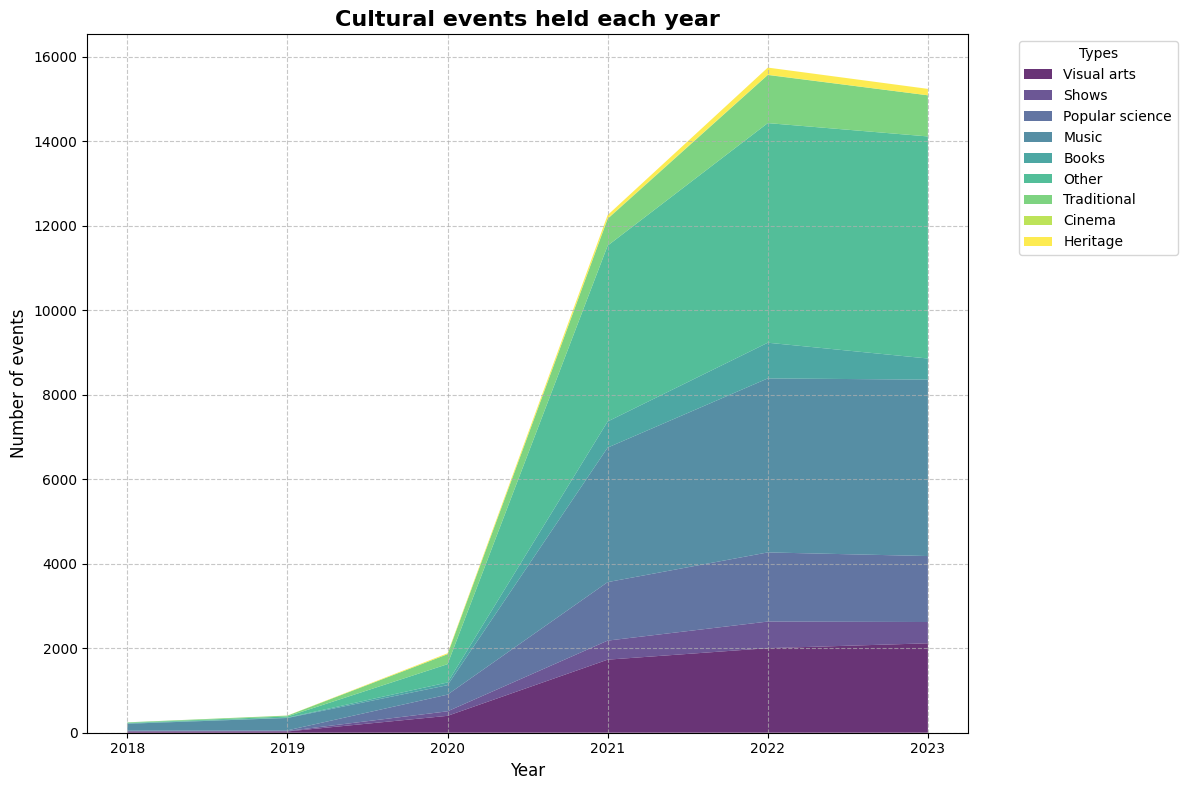

In [6]:
#Stacked plot 

data = cultura_list_ambits 
ambits = ['Visual arts', 'Shows', 'Popular science', 'Music', "Books", 'Other', 'Traditional', 'Cinema', 'Heritage']
years = [2018, 2019, 2020, 2021, 2022, 2023]

data_array = np.array(data)

viridis_colors = cm.viridis(np.linspace(0, 1, len(ambits)))


# Graphic
plt.figure(figsize=(12, 8))
plt.stackplot(years, 
              data_array.T,  
              labels=ambits,
              alpha=0.8,
              colors=viridis_colors  
              )

# Graphic configuration 
plt.title("Cultural events held each year", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of events", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Types")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig("Staked plot.png", format="png", dpi=300)

plt.show()


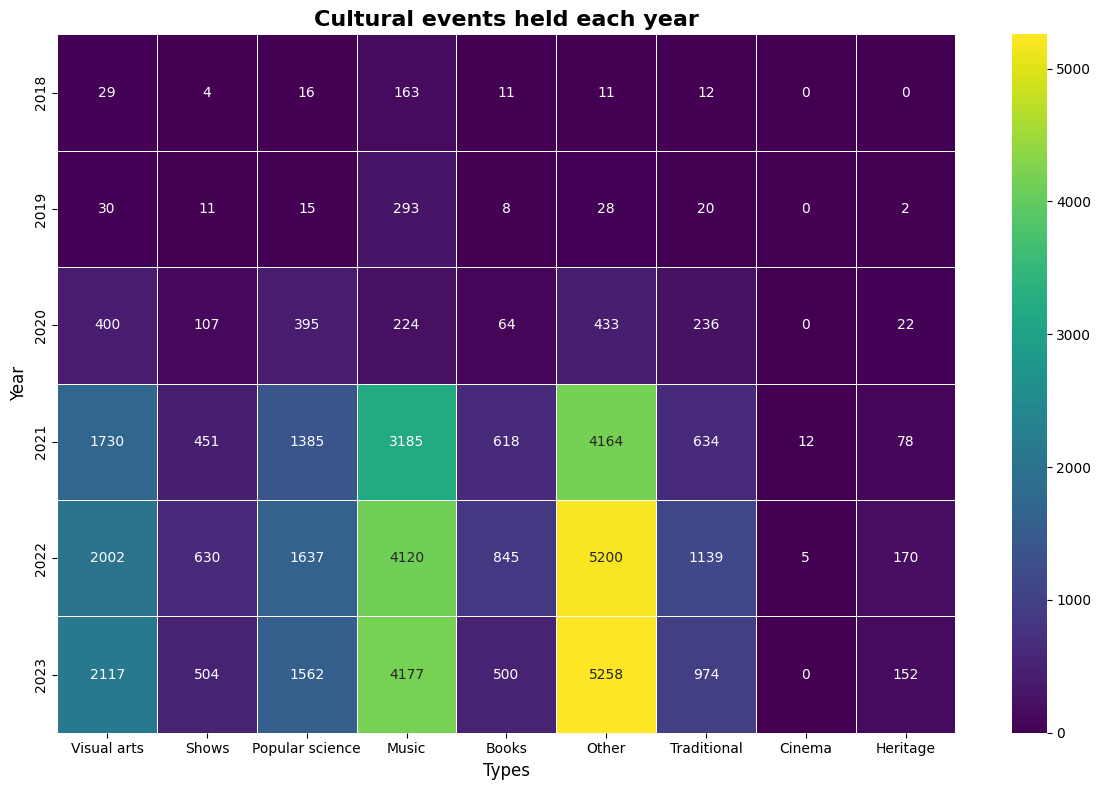

In [7]:
#Heatmap 

data = cultura_list_ambits
ambits = ['Visual arts', 'Shows','Popular science' ,'Music' ,"Books", 'Other', 'Traditional' ,'Cinema', 'Heritage']
years = [2018, 2019, 2020, 2021, 2022, 2023]

# #Creating a DataFrame
df = pd.DataFrame(data, index=years, columns=ambits)

 
#Graphic 
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt="d", cmap="viridis", linewidths=0.5)

#Graphic settings
plt.title('Cultural events held each year', fontsize=16,fontweight="bold" )
plt.xlabel('Types', fontsize=12)
plt.ylabel('Year', fontsize=12)


plt.tight_layout()
#plt.savefig("heatmap.png", format="png", dpi=300)

plt.show()


### Yearly number of cultural events by region 

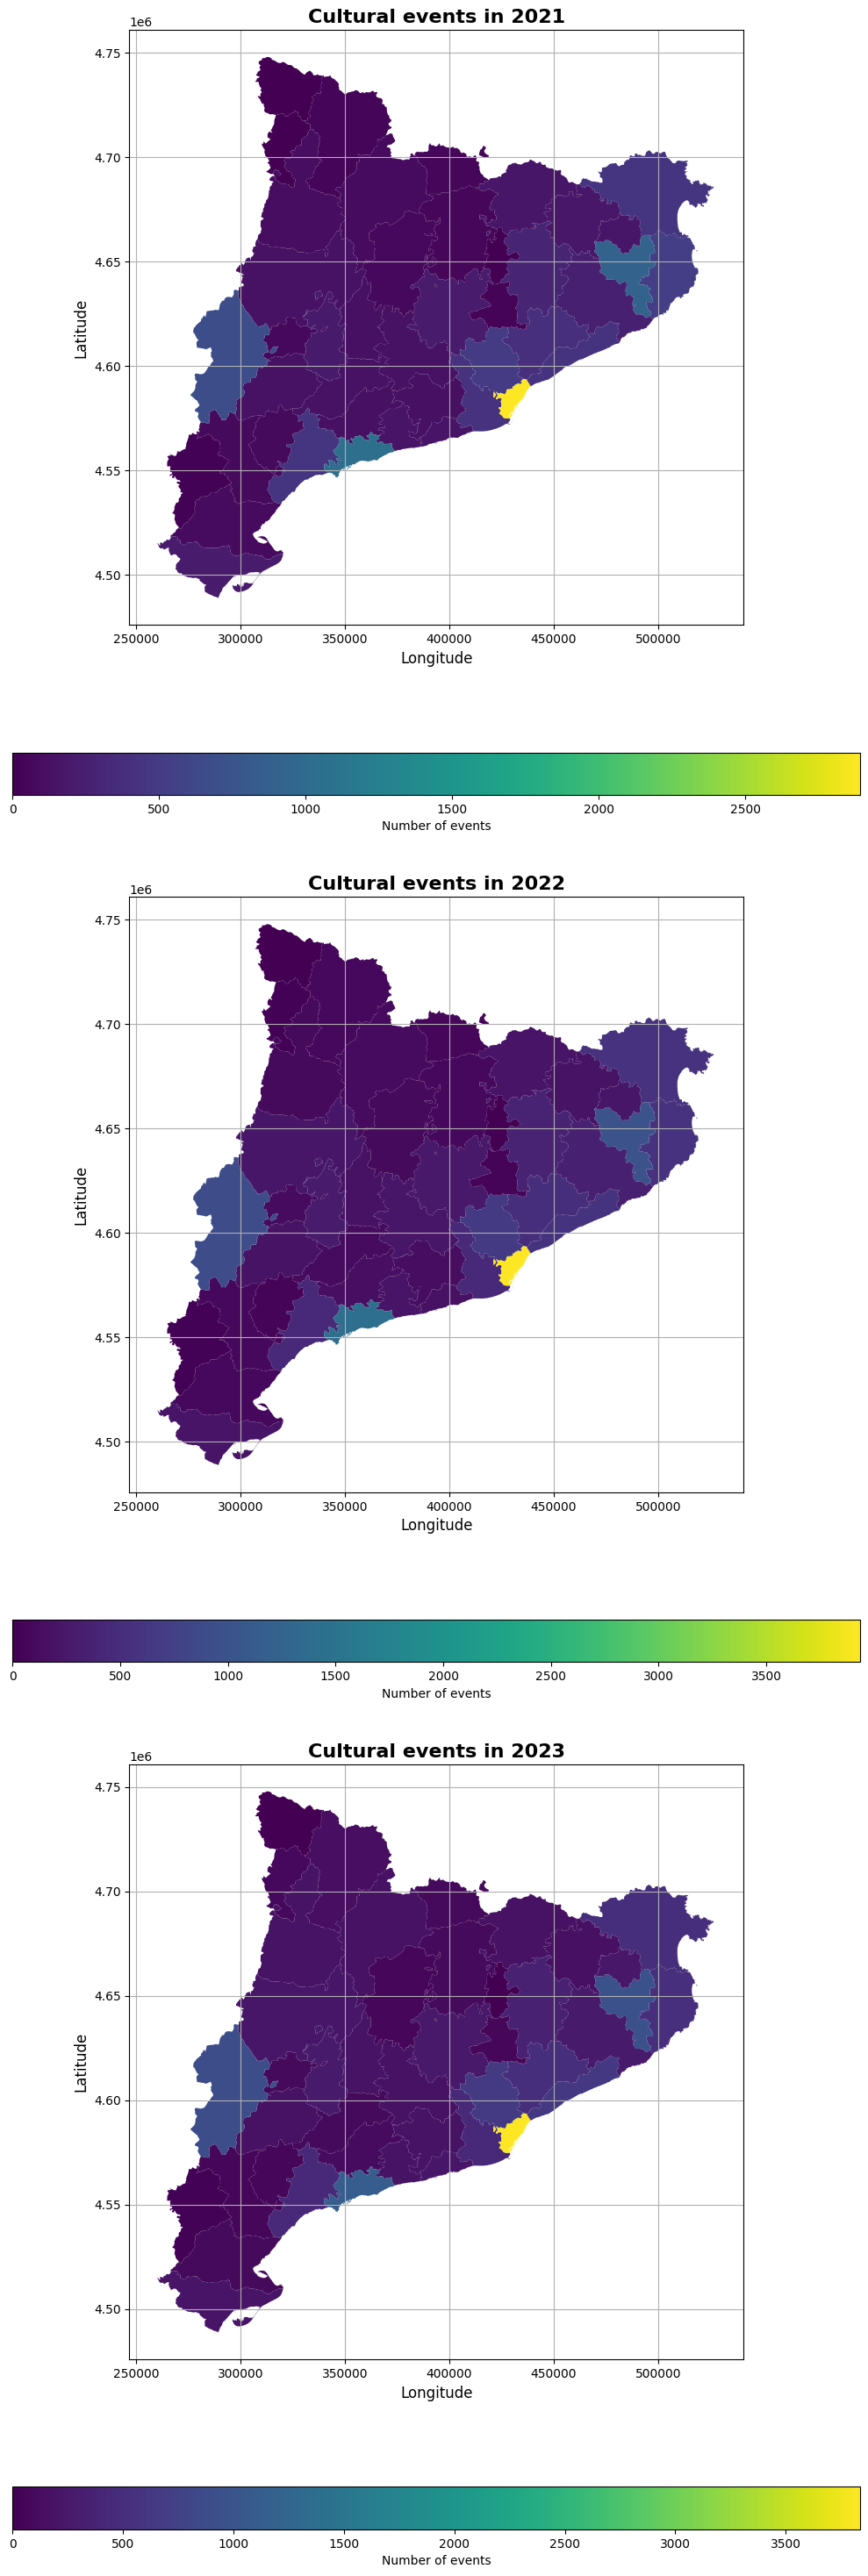

In [45]:
#Maps 

#In /divisions-administratives/ and Agenda Cultural the format of strings is not the same. So we must change the format 
#of one of them, for example the Agenda Cultural one, so as to match and locate each Comarca in the map.  
def normalize_string(s):
    s = s.lower()
    s = re.sub(r'[áàäâ]', 'a', s)
    s = re.sub(r'[éèëê]', 'e', s)
    s = re.sub(r'[íìïî]', 'i', s)
    s = re.sub(r'[óòöô]', 'o', s)
    s = re.sub(r'[úùüû]', 'u', s)
    s = re.sub(r'[ñ]', 'n', s)
    s = re.sub(r'[ç]', 'c', s)
    s = re.sub(r'aran', "val d'val d'aran", s)
    s = re.sub(r'-d-', " d'", s)
    s = re.sub(r'-l-', " l'", s)
    s = re.sub(r'-', ' ', s) 
    return s

# Load shapefiles and initialize data
dir_list_cat = [x for x in os.listdir("../data/divisions-administratives/") if x[-21:] == "-1000000-20240705.shp"]
maps = dir_list_cat[1]
comarcas = gpd.read_file(f"../data/divisions-administratives/{maps}", crs="EPSG:4326")

# Creating a subplot for each year 
years = [2021, 2022, 2023]
fig, axes = plt.subplots(3, 1, figsize=(10, 30))
axes = axes.flatten()

# Loop through each year and generate plots
for i, year in enumerate(years):
#Filter data for a specific year  
    comarcas = gpd.read_file(f"../data/divisions-administratives/{maps}", crs="EPSG:4326")
    df_year = df_tot_cultura[df_tot_cultura['data_inici'] == year]

#Putting the names in the same format as in the shapefile
    df_year.loc[:, 'municipi'] = df_year['municipi'].apply(lambda x: normalize_string(x) if pd.notnull(x) else x)
    comarcas['NOMCOMAR'] = comarcas['NOMCOMAR'].apply(lambda x: normalize_string(x))  

# Removing invalid coordinates and create geometry
    df_year = df_year[(df_year['latitud'] != 0) & (df_year['longitud'] != 0)]
    df_year.loc[:, 'geometry'] = df_year.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)
    gdf_year = gpd.GeoDataFrame(df_year, geometry='geometry', crs='EPSG:4326')

#Join comarques with the same name  
    gdf_year = gdf_year.set_index('municipi').join(comarcas, how='left', rsuffix='_comarca')
    grouped = gdf_year.groupby(gdf_year.index).size().reset_index(name='event_count')
    grouped = grouped.rename(columns={'municipi': 'NOMCOMAR'})

# Join with the shapefile
    comarcas = comarcas.reset_index().set_index('NOMCOMAR')
    grouped = grouped.set_index('NOMCOMAR')
    comarcas = comarcas.join(grouped, how='left')
    comarcas['event_count'] = comarcas['event_count'].fillna(0)

    comarcas = gpd.GeoDataFrame(comarcas, geometry='geometry')

#Map   
    ax = axes[i]
    comarcas.plot(column='event_count', ax=ax, legend=True,
                   legend_kwds={'label': "Number of events",  'spacing': "proportional", 'orientation': 'horizontal'},
                   cmap='viridis', missing_kwds={'color': 'lightgrey'})

#Map settings 
    ax.set_title(f'Cultural events in {year}', fontsize=16, fontweight = "bold")
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize =12)
    ax.grid(True)

plt.tight_layout()

plt.savefig("Mapa.png", format="png", dpi=300)
plt.show()




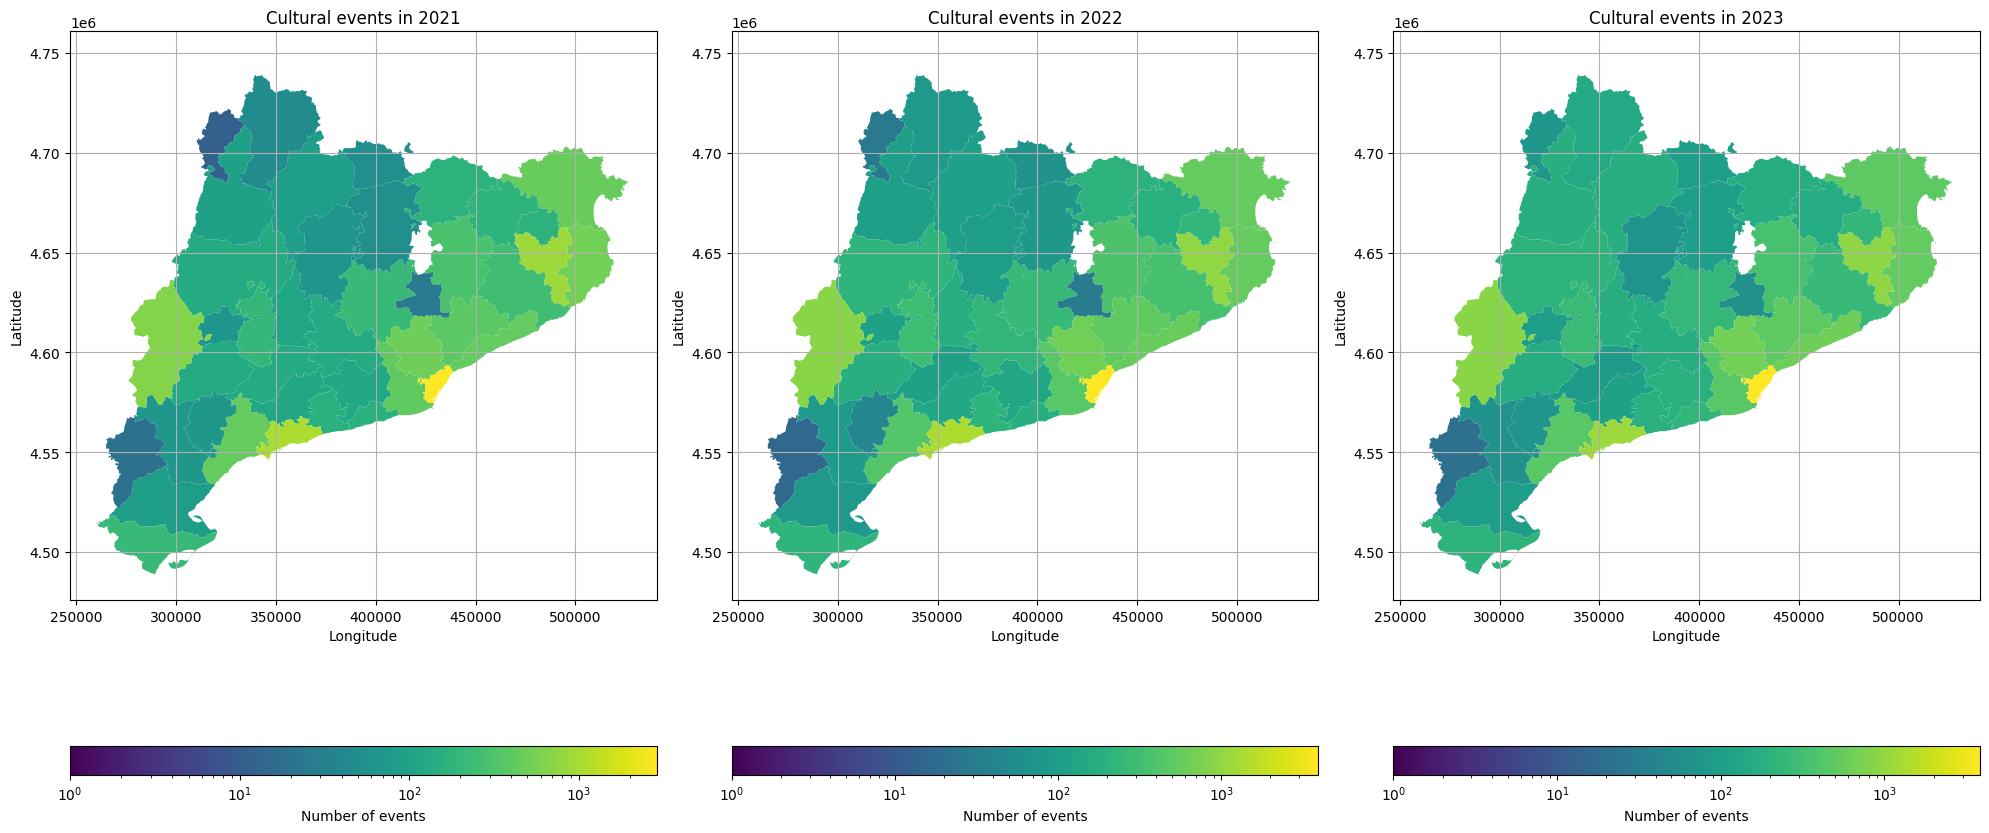

In [41]:
#Maps in logarithmic scale, to visualize better the data above 


# Load shapefiles and initialize data
dir_list_cat = [x for x in os.listdir("../data/divisions-administratives/") if x[-21:] == "-1000000-20240705.shp"]
maps = dir_list_cat[1]
comarcas = gpd.read_file(f"../data/divisions-administratives/{maps}", crs="EPSG:4326")

# Creating a subplot for each year 
years = [2021, 2022, 2023]
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes = axes.flatten()

# Loop through each year and generate plots
for i, year in enumerate(years):
#Filter data for a specific year  
    comarcas = gpd.read_file(f"../data/divisions-administratives/{maps}", crs="EPSG:4326")
    df_year = df_tot_cultura[df_tot_cultura['data_inici'] == year]

#Putting the names in the same format as in the shapefile
    df_year.loc[:, 'municipi'] = df_year['municipi'].apply(lambda x: normalize_string(x) if pd.notnull(x) else x)
    comarcas['NOMCOMAR'] = comarcas['NOMCOMAR'].apply(lambda x: normalize_string(x))  

# Removing invalid coordinates and create geometry
    df_year = df_year[(df_year['latitud'] != 0) & (df_year['longitud'] != 0)]
    df_year.loc[:, 'geometry'] = df_year.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)
    gdf_year = gpd.GeoDataFrame(df_year, geometry='geometry', crs='EPSG:4326')

#Join comarques with the same name  
    gdf_year = gdf_year.set_index('municipi').join(comarcas, how='left', rsuffix='_comarca')
    grouped = gdf_year.groupby(gdf_year.index).size().reset_index(name='event_count')
    grouped = grouped.rename(columns={'municipi': 'NOMCOMAR'})

# Join with the shapefile
    comarcas = comarcas.reset_index().set_index('NOMCOMAR')
    grouped = grouped.set_index('NOMCOMAR')
    comarcas = comarcas.join(grouped, how='left')
    comarcas['event_count'] = comarcas['event_count'].fillna(0)

    comarcas = gpd.GeoDataFrame(comarcas, geometry='geometry')

#Map   
    ax = axes[i]
    comarcas.plot(column='event_count', ax=ax, legend=True,
                   legend_kwds={'label': "Number of events", 'spacing': "proportional", 'orientation': 'horizontal'},
                   cmap='viridis', missing_kwds={'color': 'blue'},
                   norm=mpl.colors.LogNorm(vmin=comarcas['event_count'].min() + 1, vmax=comarcas['event_count'].max()))

#Map settings
    ax.set_title(f'Cultural events in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

plt.tight_layout()
plt.show()


### Relationship: events-performance 

Due to lack of information in cultural events between 2018-2020, from now on we will be only focusing in the 2021-2023 period. 

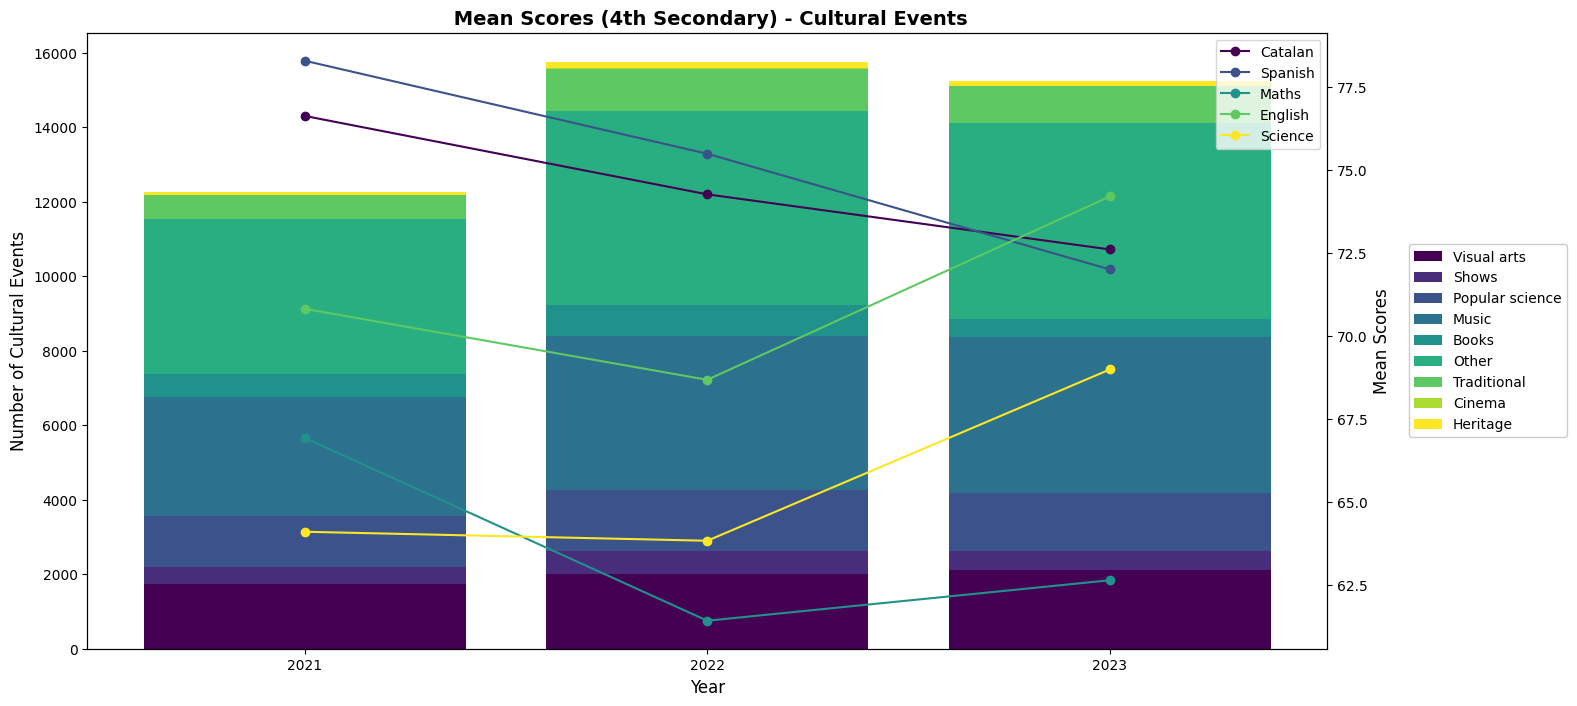

In [10]:
years = ["2021", "2022", "2023"]  
subjects = ["Catalan", "Spanish", "Maths", "English", "Science"]
events = ['Visual arts', 'Shows', 'Popular science', 'Music', 'Books', 'Other', 'Traditional', 'Cinema', 'Heritage']

# Convert data to arrays
mean_scores_4t = np.array(means_4t)
cultural_events = np.array(cultura_list_ambits)

mean_scores_4t = np.delete(mean_scores_4t, 0, axis=0)
mean_scores_4t = np.delete(mean_scores_4t, 0, axis=0)
mean_scores_4t = np.delete(mean_scores_4t, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)

viridis_events = plt.get_cmap('viridis', len(events)) 
viridis_marks = plt.get_cmap('viridis', len(subjects))

#Plot 
fig, ax1 = plt.subplots(figsize=(16, 8))

# Cultural events
bottom_values = np.zeros(len(years))
for i, color in zip(range(cultural_events.shape[1]), viridis_events.colors):  
    ax1.bar(years, cultural_events[:, i], color=color, bottom=bottom_values, label=events[i])
    bottom_values += cultural_events[:, i]

ax1.set_ylabel('Number of Cultural Events', fontsize = 12)
ax1.set_xlabel('Year', fontsize = 12 )
ax1.set_title(' Mean Scores (4th Secondary) - Cultural Events', fontsize = 14, fontweight= "bold")
ax1.legend(loc='center left', bbox_to_anchor=(1.06 , 0.5), framealpha=1) 

# Mean grades 
ax2 = ax1.twinx()
for i, color in zip(range(mean_scores_4t.shape[1]), viridis_marks.colors):
    ax2.plot(years, mean_scores_4t[:, i], color = color , marker='o', linestyle='-', label=subjects[i])


ax2.set_ylabel('Mean Scores', fontsize = 12)
ax2.legend(loc='upper right')


plt.show()


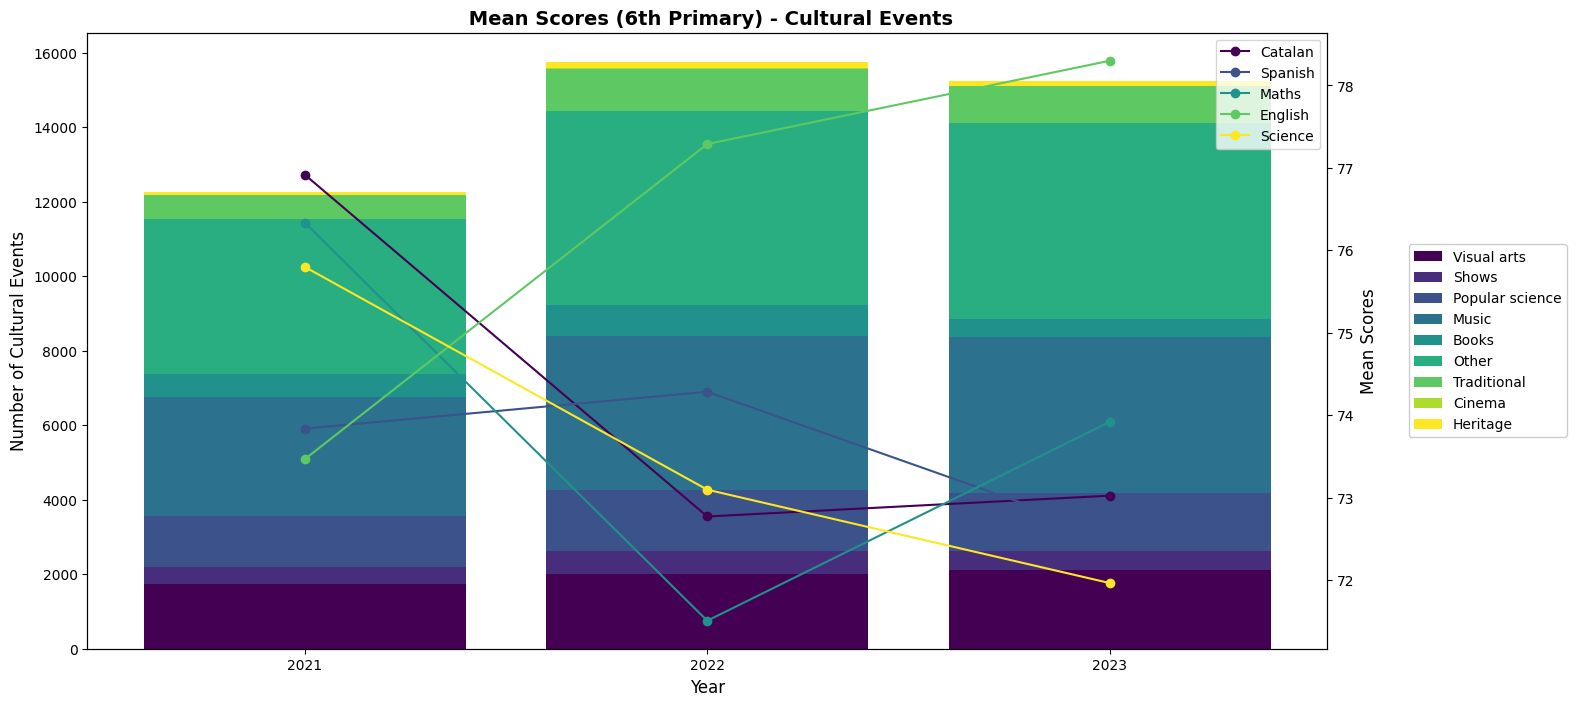

In [11]:
years = ["2021", "2022", "2023"] 
subjects = ["Catalan", "Spanish", "Maths", "English", "Science"]
events = ['Visual arts', 'Shows', 'Popular science', 'Music', 'Books', 'Other', 'Traditional', 'Cinema', 'Heritage']

# Convert data to arrays 
mean_scores_6e = np.array(means_6e)
cultural_events = np.array(cultura_list_ambits)

mean_scores_6e = np.delete(mean_scores_6e, 0, axis=0)
mean_scores_6e = np.delete(mean_scores_6e, 0, axis=0)
mean_scores_6e = np.delete(mean_scores_6e, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)

viridis_events = plt.get_cmap('viridis', len(events)) 
viridis_marks = plt.get_cmap('viridis', len(subjects))

#Plot 
fig, ax1 = plt.subplots(figsize=(16, 8))

# Cultural events 
bottom_values = np.zeros(len(years))
for i, color in zip(range(cultural_events.shape[1]), viridis_events.colors): 
    ax1.bar(years, cultural_events[:, i], bottom=bottom_values, color = color, label=events[i])
    bottom_values += cultural_events[:, i]


ax1.set_ylabel('Number of Cultural Events', fontsize = 12)
ax1.set_xlabel('Year', fontsize = 12 )
ax1.set_title(' Mean Scores (6th Primary) - Cultural Events', fontsize = 14, fontweight= "bold")
ax1.legend(loc='center left', bbox_to_anchor=(1.06 , 0.5), framealpha=1) 


# Mean grades
ax2 = ax1.twinx()
for i, color in zip(range(mean_scores_6e.shape[1]), viridis_marks.colors):
    ax2.plot(years, mean_scores_6e[:, i], marker='o', linestyle='-', color = color, label=subjects[i])

ax2.set_ylabel('Mean Scores', fontsize = 12)
ax2.legend(loc='upper right')


plt.show()


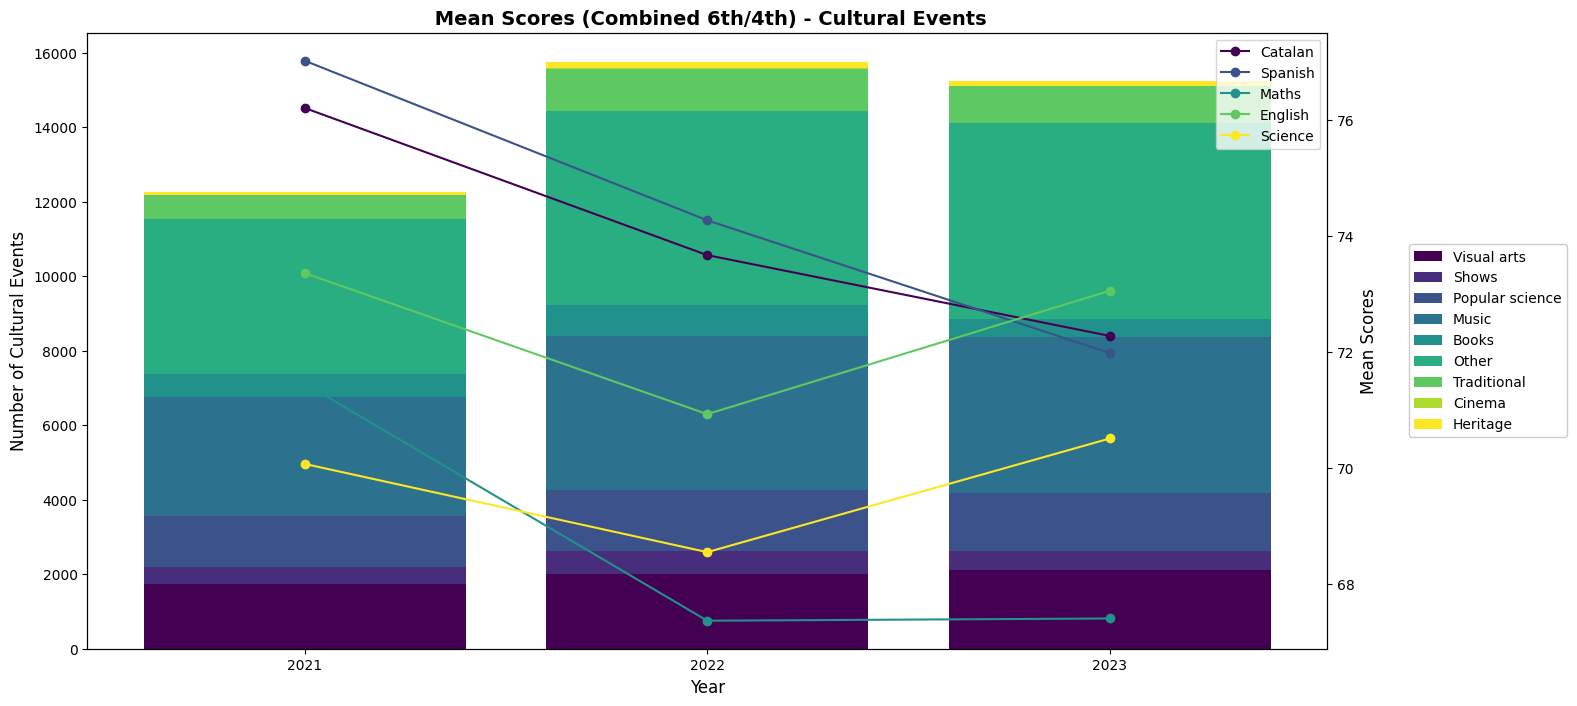

In [12]:
years = ["2021", "2022", "2023"] 
subjects = ["Catalan", "Spanish", "Maths", "English", "Science"]
events = ['Visual arts', 'Shows', 'Popular science', 'Music', 'Books', 'Other', 'Traditional', 'Cinema', 'Heritage']

# Convert to array 
mean_scores_comb = np.array(combined_means)
cultural_events = np.array(cultura_list_ambits)

mean_scores_comb = np.delete(mean_scores_comb, 0, axis=0)
mean_scores_comb = np.delete(mean_scores_comb, 0, axis=0)
mean_scores_comb = np.delete(mean_scores_comb, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)
cultural_events = np.delete(cultural_events, 0, axis=0)

viridis_events = plt.get_cmap('viridis', len(events)) 
viridis_marks = plt.get_cmap('viridis', len(subjects))

#Plot 
fig, ax1 = plt.subplots(figsize=(16, 8))

# Cultural events 
bottom_values = np.zeros(len(years))
for i, color in zip(range(cultural_events.shape[1]), viridis_events.colors): 
    ax1.bar(years, cultural_events[:, i], bottom=bottom_values, color=color,  label=events[i])
    bottom_values += cultural_events[:, i]

ax1.set_ylabel('Number of Cultural Events', fontsize = 12)
ax1.set_xlabel('Year', fontsize = 12 )
ax1.set_title(' Mean Scores (Combined 6th/4th) - Cultural Events', fontsize = 14, fontweight= "bold")
ax1.legend(loc='center left', bbox_to_anchor=(1.06 , 0.5), framealpha=1) 

#Mean grades 
ax2 = ax1.twinx()
for i, color in zip(range(mean_scores_comb.shape[1]), viridis_marks.colors):
    ax2.plot(years, mean_scores_comb[:, i], marker='o', color = color,  linestyle='-', label=subjects[i])

ax2.set_ylabel('Mean Scores', fontsize = 12)
ax2.legend(loc='upper right')

# Mostrar la gráfica
plt.show()


This last plots are rather confising and do not provide any significant information about the relationship between performance of the students and the number of cultural events. Therefore, we will try to relate some types of events with results in certain subjects instead, to see if here we can extract better conclusions. 

## Relationship: types of events-performance by subject

### Manipulation of the data 

Because the cultural events are listed by comarca (or municipi) and the results in Competències Bàsiques are distributed by determined territorial regions, we are going to manually  put each comarca in its corresponding area. 

In [13]:
#Pairing each comarca with the corresponding region. 

area_mapping = {
    'solsones': 'Catalunya Central',
    'alt-emporda': 'Girona',
    'baix-emporda': 'Girona',
    'aran': 'Lleida',
    'bages': 'Catalunya Central',
    'bergueda': 'Catalunya Central',
    'garrigues': 'Lleida',
    'tarragones': 'Tarragona',
    'osona': 'Catalunya Central',
    'valles-occidental': 'Vallès Occidental',
    'maresme': 'Maresme - Vallès Oriental',
    'pla-d-urgell': 'Lleida',
    'selva': 'Maresme - Vallès Oriental',
    'pla-de-l-estany': 'Girona',
    'barcelones': 'Consorci d\'Educació de Barcelona',
    'ripolles': 'Girona',
    'noguera': 'Lleida',
    'valles-oriental': 'Maresme - Vallès Oriental',
    'urgell': 'Lleida',
    'baix-ebre': 'Terres de l’Ebre',
    'segarra': 'Lleida',
    'baix-camp': 'Tarragona',
    'terra-alta': 'Terres de l’Ebre',
    'montsia': 'Terres de l’Ebre',
    'moianes': 'Catalunya Central',
    'baix-llobregat': 'Baix Llobregat',
    'segria': 'Lleida',
    'baix-penedes': 'Tarragona',
    'garrotxa': 'Girona',
    'girones': 'Girona',
    'alta-ribagorca': 'Lleida',
    'priorat': 'Tarragona',
    'ribera-d-ebre': 'Terres de l’Ebre',
    'alt-penedes': 'Barcelona Comarques',
    'conca-de-barbera': 'Tarragona',
    'garraf': 'Barcelona Comarques',
    'anoia': 'Barcelona Comarques',
    'lleida': 'Lleida',
    'girona': 'Girona',
    'pallars-jussa': 'Lleida',
    'alt-camp': 'Tarragona',
    'cerdanya': 'Lleida',
    'alt-urgell': 'Lleida',
    'pallars-sobira': 'Lleida',
    'barcelona': 'Consorci d\'Educació de Barcelona',
    'tarragona': 'Tarragona',
    'barcelona,agenda:ubicacions': 'Consorci d\'Educació de Barcelona',
    'agenda:ubicacions': 'Consorci d\'Educació de Barcelona'
}

# Add the new column to the dataframe 
df_tot_cultura['area_territorial'] = df_tot_cultura['municipi'].map(area_mapping)




In [14]:
#Transforming the columns we're going to manipulate in numerical values 

df_tot_comp_4t['pcast_4t'] = pd.to_numeric(df_tot_comp_4t['pcast_4t'], errors='coerce')
df_tot_comp_4t['pcat_4t'] =  pd.to_numeric(df_tot_comp_4t['pcat_4t'], errors='coerce')
df_tot_comp_6e["pcast_6e"] = pd.to_numeric(df_tot_comp_6e['pcast_6e'], errors='coerce')
df_tot_comp_6e["pcat_6e"] = pd.to_numeric(df_tot_comp_6e['pcat_6e'], errors='coerce')
df_tot_comp_4t['any_4t'] = pd.to_numeric(df_tot_comp_4t['any_4t'], errors='coerce')
df_tot_comp_6e['any_6e'] = pd.to_numeric(df_tot_comp_6e['any_6e'], errors='coerce')

df_tot_comp_4t['pmat_4t'] = pd.to_numeric(df_tot_comp_4t['pmat_4t'], errors='coerce')
df_tot_comp_4t['pcien_4t'] =  pd.to_numeric(df_tot_comp_4t['pcien_4t'], errors='coerce')
df_tot_comp_6e["pmat_6e"] = pd.to_numeric(df_tot_comp_6e['pmat_6e'], errors='coerce')
df_tot_comp_6e["pcien_6e"] = pd.to_numeric(df_tot_comp_6e['pcien_6e'], errors='coerce')


### Display of the data -  Linear relationships  

Languages - Book type events

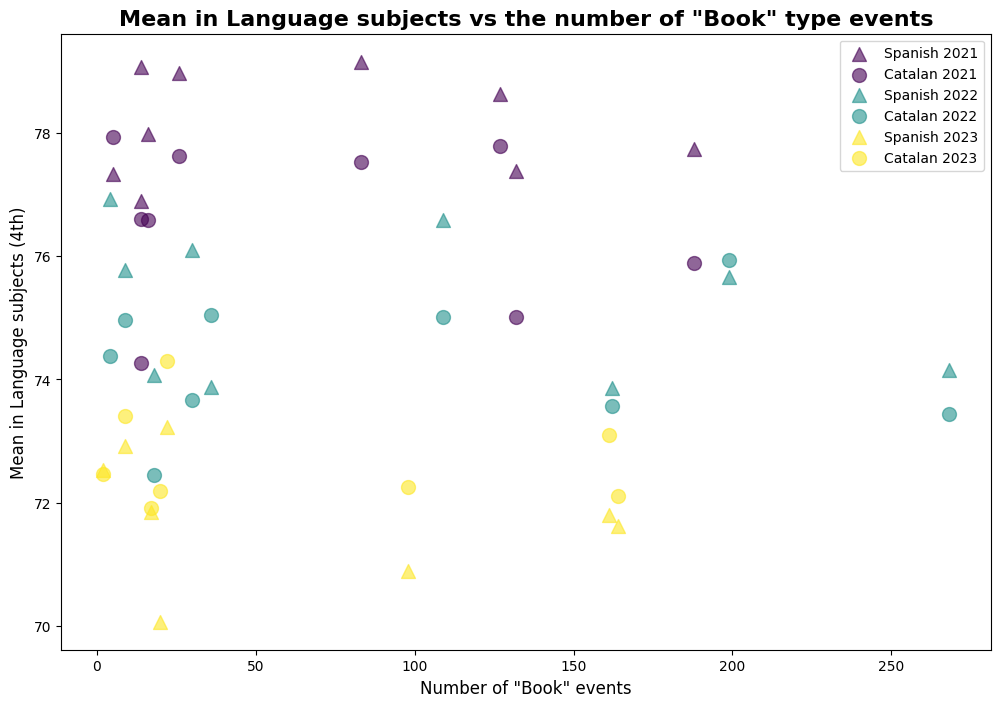

In [15]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]

colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))

for year, color in zip(years, colors):
    df_notas_year = df_tot_comp_4t_1[df_tot_comp_4t_1['any_4t'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'llibres-i-lletres')
    ].copy()

# Means by area
    media_notas_cast = df_notas_year.groupby('area_territorial_4t')['pcast_4t'].mean().reset_index()
    media_notas_cast.columns = ['area_territorial_4t', 'pcast']
    media_notas_cat = df_notas_year.groupby('area_territorial_4t')['pcat_4t'].mean().reset_index()
    media_notas_cat.columns = ['area_territorial_4t', 'pcat']

#Events by area 
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')
    
#Rename the column and merge 
    media_notas_cast.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)
    media_notas_cat.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)

    df_combined_cast = pd.merge(media_notas_cast, eventos_count, on='area_territorial', how='inner')
    df_combined_cat = pd.merge(media_notas_cat, eventos_count, on='area_territorial', how='inner')

#Plot
    plt.scatter(df_combined_cast['num_eventos'], df_combined_cast['pcast'],
                color=color, alpha=0.6, marker='^', s= 100 , label=f'Spanish {year}')
    plt.scatter(df_combined_cat['num_eventos'], df_combined_cat['pcat'],
                color=color, alpha=0.6, marker='o', s =100, label=f'Catalan {year}')

# Plot settings 
plt.xlabel('Number of "Book" events', fontsize =12)
plt.ylabel('Mean in Language subjects (4th)', fontsize=12)
plt.title('Mean in Language subjects vs the number of "Book" type events', fontsize=16,  fontweight="bold")
plt.legend()
#plt.grid(True)

#plt.savefig("Llibres-llengues-4t.png", format="png", dpi=300)

plt.show()


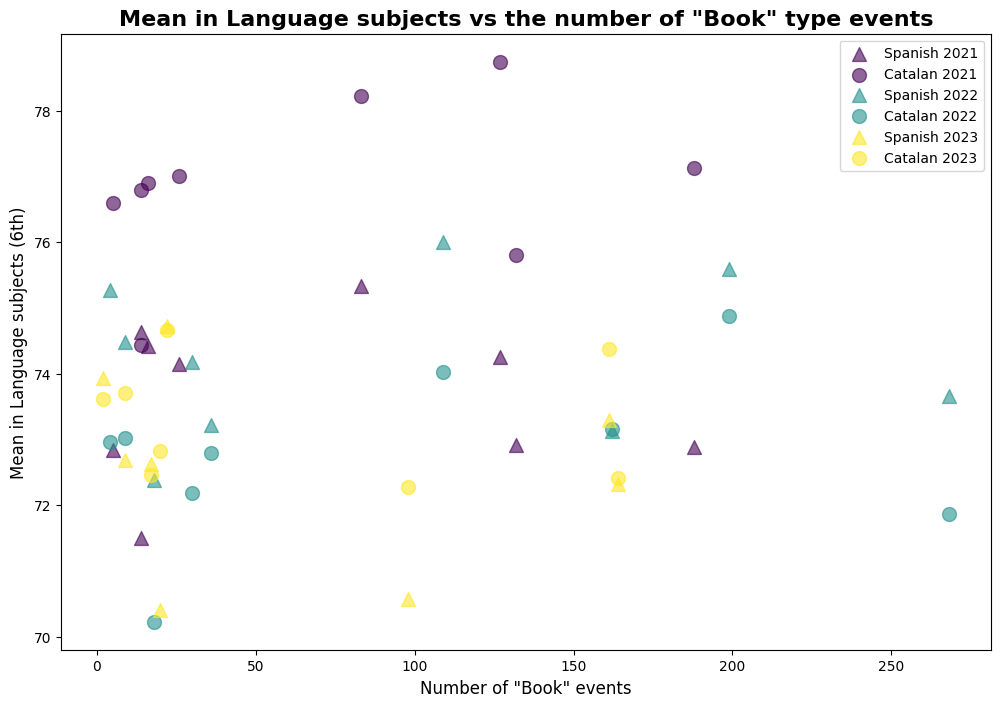

In [16]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))


for year, color in zip(years, colors):
    df_notas_year = df_tot_comp_6e_1[df_tot_comp_6e_1['any_6e'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'llibres-i-lletres')
    ].copy()

#Means by area 
    media_notas_cast = df_notas_year.groupby('area_territorial_6e')['pcast_6e'].mean().reset_index()
    media_notas_cast.columns = ['area_territorial_6e', 'pcast']
    media_notas_cat = df_notas_year.groupby('area_territorial_6e')['pcat_6e'].mean().reset_index()
    media_notas_cat.columns = ['area_territorial_6e', 'pcat']
    
#Events by area 
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Rename the column and merge 
    media_notas_cast.rename(columns={'area_territorial_6e': 'area_territorial'}, inplace=True)
    media_notas_cat.rename(columns={'area_territorial_6e': 'area_territorial'}, inplace=True)

    df_combined_cast = pd.merge(media_notas_cast, eventos_count, on='area_territorial', how='inner')
    df_combined_cat = pd.merge(media_notas_cat, eventos_count, on='area_territorial', how='inner')

#Plot 
    plt.scatter(df_combined_cast['num_eventos'], df_combined_cast['pcast'],
                color=color, alpha=0.6, marker='^', s=100,  label=f'Spanish {year}')
    plt.scatter(df_combined_cat['num_eventos'], df_combined_cat['pcat'],
                color=color, alpha=0.6, marker='o', s=100, label=f'Catalan {year}')

# Plot settings 
plt.xlabel('Number of "Book" events', fontsize =12)
plt.ylabel('Mean in Language subjects (6th)', fontsize=12)
plt.title('Mean in Language subjects vs the number of "Book" type events', fontsize=16,  fontweight="bold")
plt.legend()
#plt.grid(True) 


plt.show()


Sciences -  Popular science events

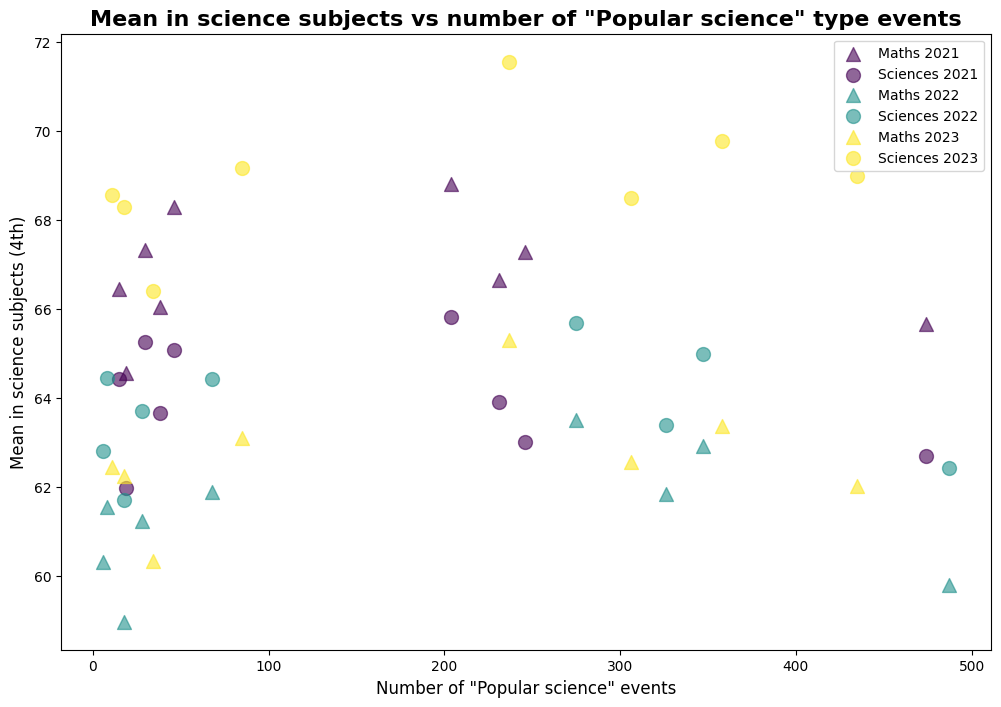

In [46]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))


for year, color in zip(years, colors):
    df_notas_year = df_tot_comp_4t_1[df_tot_comp_4t_1['any_4t'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'divulgacio')
    ].copy()


#Means by area
    media_notas_mat = df_notas_year.groupby('area_territorial_4t')['pmat_4t'].mean().reset_index()
    media_notas_mat.columns = ['area_territorial_4t', 'pmat']
    media_notas_cien = df_notas_year.groupby('area_territorial_4t')['pcien_4t'].mean().reset_index()
    media_notas_cien.columns = ['area_territorial_4t', 'pcien']

#Events by area 
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Rename the column and merge
    media_notas_mat.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)
    media_notas_cien.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)

    df_combined_mat = pd.merge(media_notas_mat, eventos_count, on='area_territorial', how='inner')
    df_combined_cien = pd.merge(media_notas_cien, eventos_count, on='area_territorial', how='inner')
    
#Plot 
    plt.scatter(df_combined_mat['num_eventos'], df_combined_mat['pmat'],
                color=color, alpha=0.6, marker='^', s=100,  label=f'Maths {year}')
    plt.scatter(df_combined_cien['num_eventos'], df_combined_cien['pcien'],
                color=color, alpha=0.6, marker='o', s=100, label=f'Sciences {year}')

# Plot settings 
plt.xlabel('Number of "Popular science" events', fontsize =12)
plt.ylabel('Mean in science subjects (4th)', fontsize=12)
plt.title('Mean in science subjects vs number of "Popular science" type events', fontsize=16,  fontweight="bold")
plt.legend()
#plt.grid(True)
plt.savefig("popular science-ciencies-4t.png", format="png", dpi=300)
plt.show()

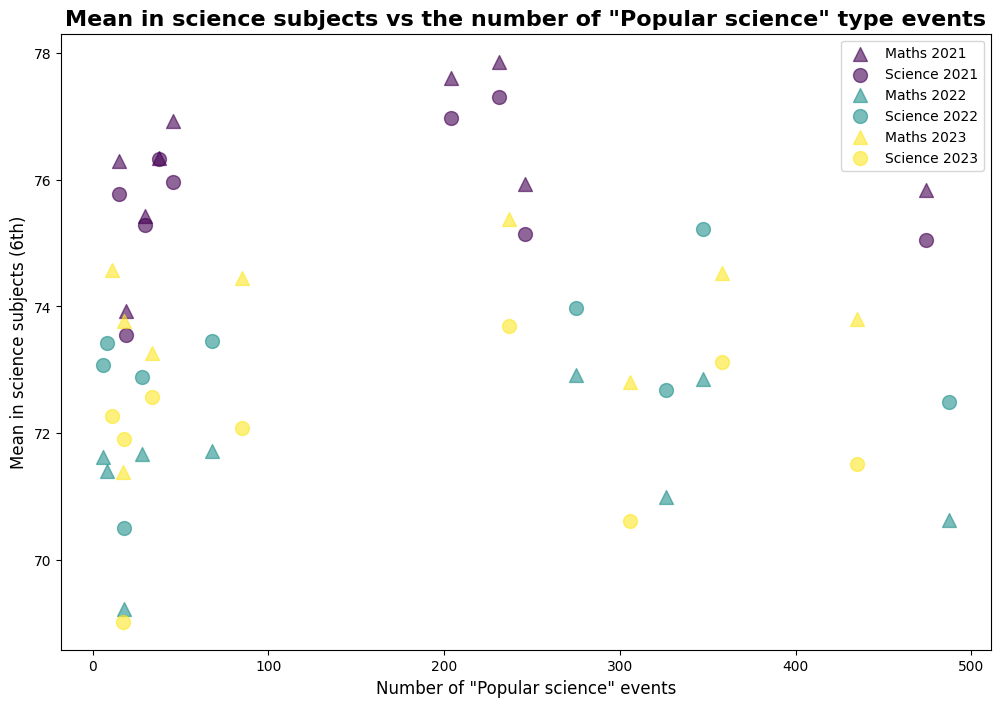

In [18]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))

for year, color in zip(years, colors):
    df_notas_year = df_tot_comp_6e_1[df_tot_comp_6e_1['any_6e'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'divulgacio')
    ].copy()

#Means by area 
    media_notas_mat = df_notas_year.groupby('area_territorial_6e')['pmat_6e'].mean().reset_index()
    media_notas_mat.columns = ['area_territorial_6e', 'pmat']
    media_notas_cien = df_notas_year.groupby('area_territorial_6e')['pcien_6e'].mean().reset_index()
    media_notas_cien.columns = ['area_territorial_6e', 'pcien']

#Means by event
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Rename the columns and merge    
    media_notas_mat.rename(columns={'area_territorial_6e': 'area_territorial'}, inplace=True)
    media_notas_cien.rename(columns={'area_territorial_6e': 'area_territorial'}, inplace=True)
    
    df_combined_mat = pd.merge(media_notas_mat, eventos_count, on='area_territorial', how='inner')
    df_combined_cien = pd.merge(media_notas_cien, eventos_count, on='area_territorial', how='inner')

#Plot 
    plt.scatter(df_combined_mat['num_eventos'], df_combined_mat['pmat'],
                color=color, alpha=0.6, marker='^', s=100,  label=f'Maths {year}')
    plt.scatter(df_combined_cien['num_eventos'], df_combined_cien['pcien'],
                color=color, alpha=0.6, marker='o', s=100,  label=f'Science {year}')

    
# Plot settings 
plt.xlabel('Number of "Popular science" events', fontsize =12)
plt.ylabel('Mean in science subjects (6th)', fontsize=12)
plt.title('Mean in science subjects vs the number of "Popular science" type events', fontsize=16,  fontweight="bold")
plt.legend()


#plt.grid(True)

plt.show()

Sciences - Music events

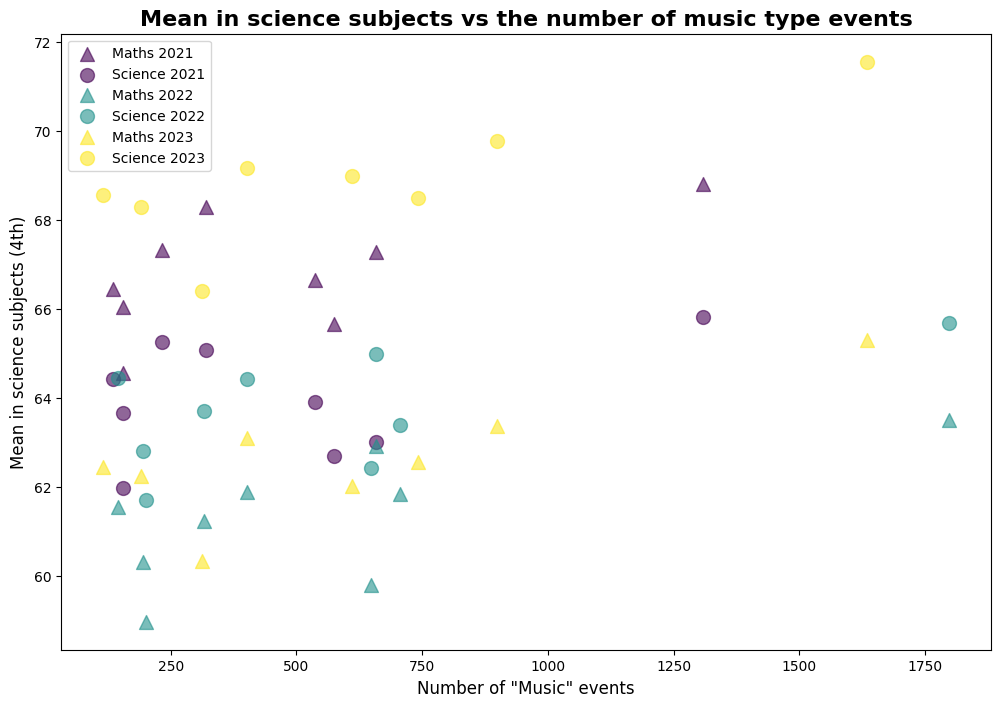

In [19]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))


for year, color in zip(years, colors):
    # Filtrar datos del año actual
    df_notas_year = df_tot_comp_4t_1[df_tot_comp_4t_1['any_4t'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'musica')
    ].copy()

#Means by area 
    media_notas_mat = df_notas_year.groupby('area_territorial_4t')['pmat_4t'].mean().reset_index()
    media_notas_mat.columns = ['area_territorial_4t', 'pmat']
    media_notas_cien = df_notas_year.groupby('area_territorial_4t')['pcien_4t'].mean().reset_index()
    media_notas_cien.columns = ['area_territorial_4t', 'pcien']

#Means by event 
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Rename and merging 
    media_notas_mat.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)
    media_notas_cien.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)

    df_combined_mat = pd.merge(media_notas_mat, eventos_count, on='area_territorial', how='inner')
    df_combined_cien = pd.merge(media_notas_cien, eventos_count, on='area_territorial', how='inner')


    plt.scatter(df_combined_mat['num_eventos'], df_combined_mat['pmat'],
                color=color, alpha=0.6, marker='^', s = 100 , label=f'Maths {year}')
    plt.scatter(df_combined_cien['num_eventos'], df_combined_cien['pcien'],
                color=color, alpha=0.6, marker='o', s =100 , label=f'Science {year}')
    
    

# Plot settings 
plt.xlabel('Number of "Music" events', fontsize = 12)
plt.ylabel('Mean in science subjects (4th)', fontsize =12 )
plt.title('Mean in science subjects vs the number of music type events', fontsize =16, fontweight = "bold")
plt.legend()
#plt.grid(True)
plt.savefig("Musica-ciencies-4t.png", format="png", dpi=300)
plt.show()

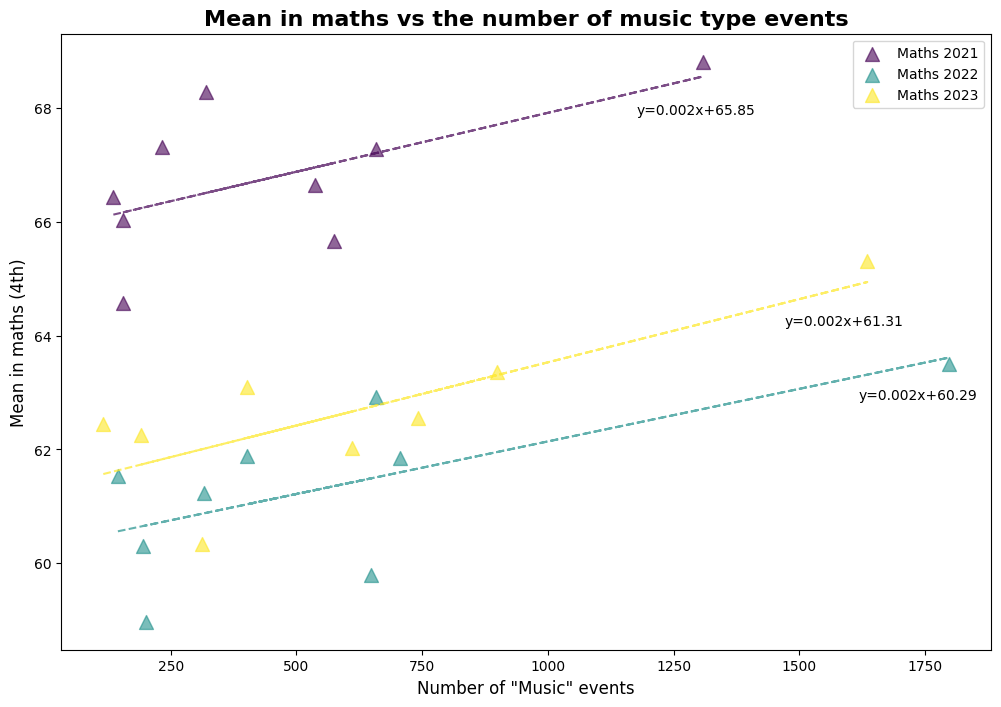

In [20]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))


for year, color in zip(years, colors):
    # Filtrar datos del año actual
    df_notas_year = df_tot_comp_4t_1[df_tot_comp_4t_1['any_4t'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'musica')
    ].copy()

#Means by area 
    media_notas_mat = df_notas_year.groupby('area_territorial_4t')['pmat_4t'].mean().reset_index()
    media_notas_mat.columns = ['area_territorial_4t', 'pmat']
    media_notas_cien = df_notas_year.groupby('area_territorial_4t')['pcien_4t'].mean().reset_index()
    media_notas_cien.columns = ['area_territorial_4t', 'pcien']

#Means by event 
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Rename and merging 
    media_notas_mat.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)
    media_notas_cien.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)

    df_combined_mat = pd.merge(media_notas_mat, eventos_count, on='area_territorial', how='inner')
    df_combined_cien = pd.merge(media_notas_cien, eventos_count, on='area_territorial', how='inner')


    plt.scatter(df_combined_mat['num_eventos'], df_combined_mat['pmat'],
                color=color, alpha=0.6, marker='^', s = 100 , label=f'Maths {year}')
#    plt.scatter(df_combined_cien['num_eventos'], df_combined_cien['pcien'],
#                color=color, alpha=0.6, marker='o', s =100 , label=f'Science {year}')

#Regression    
    if len(df_combined_mat) > 1:  
        z_mat = np.polyfit(df_combined_mat['num_eventos'], df_combined_mat['pmat'], 1)
        p_mat = np.poly1d(z_mat)
        plt.plot(df_combined_mat['num_eventos'], p_mat(df_combined_mat['num_eventos']),
                 color=color, linestyle='--', alpha=0.7)
        x_pos_mat = df_combined_mat['num_eventos'].max() - 0.1 * df_combined_mat['num_eventos'].max()
        y_pos_mat = p_mat(x_pos_mat) - 0.4  # Baja la ecuación en el eje y
        plt.text(x_pos_mat, y_pos_mat,
                 f'y={z_mat[0]:.3f}x+{z_mat[1]:.2f}', fontsize=10, color="black")
#    if len(df_combined_cien) > 1:  
#        z_cien = np.polyfit(df_combined_cien['num_eventos'], df_combined_cien['pcien'], 1)
#        p_cien = np.poly1d(z_cien)
#        plt.plot(df_combined_cien['num_eventos'], p_cien(df_combined_cien['num_eventos']),
#                 color=color, linestyle='-', alpha=0.7)

# Plot settings 
plt.xlabel('Number of "Music" events', fontsize = 12)
plt.ylabel('Mean in maths (4th)', fontsize =12 )
plt.title('Mean in maths vs the number of music type events', fontsize =16, fontweight = "bold")
plt.legend()
#plt.grid(True)
plt.savefig("Musica-mates-4t-reg.png", format="png", dpi=300)
plt.show()




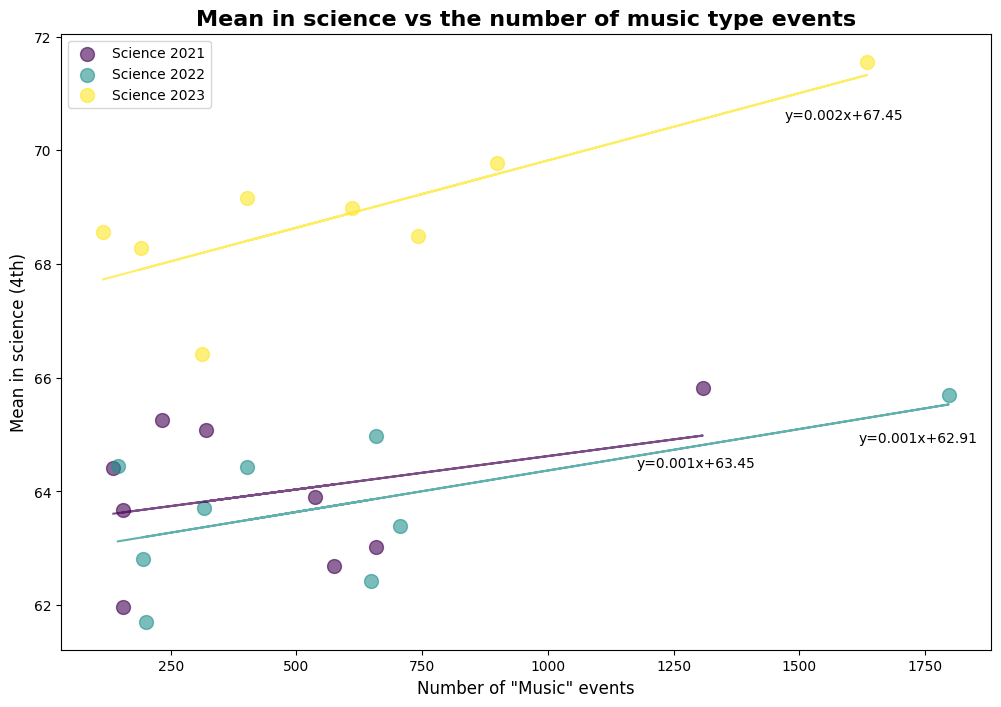

In [47]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))


for year, color in zip(years, colors):
    # Filtrar datos del año actual
    df_notas_year = df_tot_comp_4t_1[df_tot_comp_4t_1['any_4t'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'musica')
    ].copy()

#Means by area 
    media_notas_mat = df_notas_year.groupby('area_territorial_4t')['pmat_4t'].mean().reset_index()
    media_notas_mat.columns = ['area_territorial_4t', 'pmat']
    media_notas_cien = df_notas_year.groupby('area_territorial_4t')['pcien_4t'].mean().reset_index()
    media_notas_cien.columns = ['area_territorial_4t', 'pcien']

#Means by event 
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Rename and merging 
    media_notas_mat.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)
    media_notas_cien.rename(columns={'area_territorial_4t': 'area_territorial'}, inplace=True)

    df_combined_mat = pd.merge(media_notas_mat, eventos_count, on='area_territorial', how='inner')
    df_combined_cien = pd.merge(media_notas_cien, eventos_count, on='area_territorial', how='inner')


#    plt.scatter(df_combined_mat['num_eventos'], df_combined_mat['pmat'],
#                color=color, alpha=0.6, marker='^', s = 100 , label=f'Maths {year}')
    plt.scatter(df_combined_cien['num_eventos'], df_combined_cien['pcien'],
                color=color, alpha=0.6, marker='o', s =100 , label=f'Science {year}')

#Regression    
#    if len(df_combined_mat) > 1:  
#        z_mat = np.polyfit(df_combined_mat['num_eventos'], df_combined_mat['pmat'], 1)
#        p_mat = np.poly1d(z_mat)
#        plt.plot(df_combined_mat['num_eventos'], p_mat(df_combined_mat['num_eventos']),
#                 color=color, linestyle='--', alpha=0.7)
#        x_pos_mat = df_combined_mat['num_eventos'].max() - 0.1 * df_combined_mat['num_eventos'].max()
#        y_pos_mat = p_mat(x_pos_mat) - 0.4  # Baja la ecuación en el eje y
#        plt.text(x_pos_mat, y_pos_mat,
#                 f'y={z_mat[0]:.3f}x+{z_mat[1]:.2f}', fontsize=10, color="black")
    if len(df_combined_cien) > 1:  
        z_cien = np.polyfit(df_combined_cien['num_eventos'], df_combined_cien['pcien'], 1)
        p_cien = np.poly1d(z_cien)
        plt.plot(df_combined_cien['num_eventos'], p_cien(df_combined_cien['num_eventos']),
                 color=color, linestyle='-', alpha=0.7)
        
        x_pos_cien = df_combined_cien['num_eventos'].max() - 0.1 * df_combined_cien['num_eventos'].max()
        y_pos_cien = p_cien(x_pos_cien) - 0.4  # Baja la ecuación en el eje y
        plt.text(x_pos_cien, y_pos_cien,
                 f'y={z_cien[0]:.3f}x+{z_cien[1]:.2f}', fontsize=10, color="black")

# Plot settings 
plt.xlabel('Number of "Music" events', fontsize = 12)
plt.ylabel('Mean in science (4th)', fontsize =12 )
plt.title('Mean in science vs the number of music type events', fontsize =16, fontweight = "bold")
plt.legend()
#plt.grid(True)
plt.savefig("Musica-ciencies-4t-reg.png", format="png", dpi=300)
plt.show()




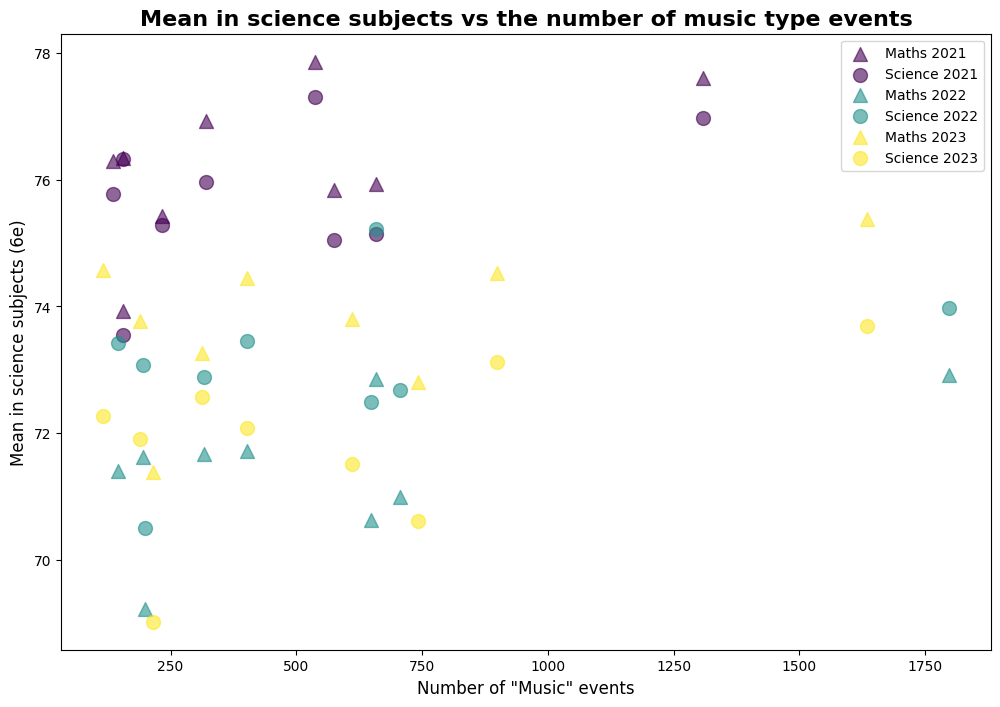

In [21]:
#We crate copies so as to not compromise the original DataFrames 
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_comp_6e_1 =  df_tot_comp_6e.copy()
df_tot_cultura_1= df_tot_cultura.copy() 

years = [2021, 2022, 2023]
colors = cm.viridis(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 8))


for year, color in zip(years, colors):
    df_notas_year = df_tot_comp_6e_1[df_tot_comp_6e_1['any_6e'] == year]
    df_cultura_year = df_tot_cultura_1[
        (df_tot_cultura_1['data_inici'] == year) &
        (df_tot_cultura_1['tags_mbits'] == 'musica')
    ].copy()

#Mean by area 
    media_notas_mat = df_notas_year.groupby('area_territorial_6e')['pmat_6e'].mean().reset_index()
    media_notas_mat.columns = ['area_territorial_6e', 'pmat']
    media_notas_cien = df_notas_year.groupby('area_territorial_6e')['pcien_6e'].mean().reset_index()
    media_notas_cien.columns = ['area_territorial_6e', 'pcien']

#Mean by event
    eventos_count = df_cultura_year.groupby('area_territorial').size().reset_index(name='num_eventos')

#Renaming and merge 
    media_notas_mat.rename(columns={'area_territorial_6e': 'area_territorial'}, inplace=True)
    media_notas_cien.rename(columns={'area_territorial_6e': 'area_territorial'}, inplace=True)

    df_combined_mat = pd.merge(media_notas_mat, eventos_count, on='area_territorial', how='inner')
    df_combined_cien = pd.merge(media_notas_cien, eventos_count, on='area_territorial', how='inner')


#Plot 
    plt.scatter(df_combined_mat['num_eventos'], df_combined_mat['pmat'],
                color=color, alpha=0.6, s =100, marker='^', label=f'Maths {year}')
    plt.scatter(df_combined_cien['num_eventos'], df_combined_cien['pcien'],
                color=color, alpha=0.6, marker='o', s=100, label=f'Science {year}')

# Plot settings 
plt.xlabel('Number of "Music" events', fontsize = 12)
plt.ylabel('Mean in science subjects (6th)', fontsize = 12 )
plt.title('Mean in science subjects vs the number of music type events', fontweight = "bold", fontsize =16 )
plt.legend()
#plt.grid(True)

#plt.savefig("Musica-ciencies-6e.png", format="png", dpi=300)

plt.show()

### Display of the data -  Proportions 

Languages - Book type events

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\3318752218.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


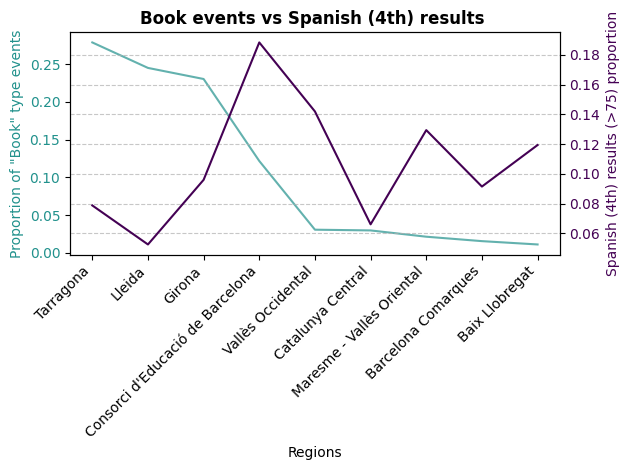

In [22]:
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_cultura_1 = df_tot_cultura.copy()


df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "llibres-i-lletres"]

# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()



#Count results in Spanish and take the part of the marks bigger than 75, as it is considered to be the mean and 
#we want to study the results above it  
df_tot_comp_4t_1["pcast_4t"] = pd.to_numeric(df_tot_comp_4t_1["pcast_4t"], errors="coerce")
df_castellano_75 = df_tot_comp_4t_1[df_tot_comp_4t_1["pcast_4t"] > 75]
proporcion_por_comarca = (df_castellano_75.groupby("area_territorial_4t")["pcast_4t"].count().reset_index(name="count"))

# Compute the proportions 
proporcion_por_comarca["proportion"] = (proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum())
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)

proporcion_por_comarca["Inverse_CDF_b"] = 1- proporcion_por_comarca["proportion"].cumsum()

# Match comarques in culture and results dataframe and 
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_4t",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Book" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Spanish (4th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Book events vs Spanish (4th) results ", fontweight="bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\3951343829.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


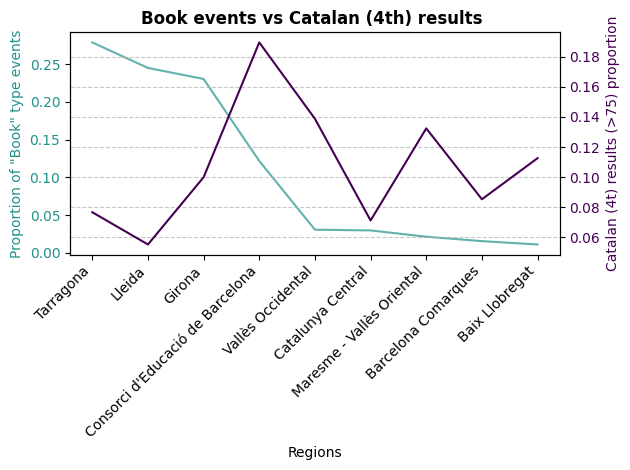

In [23]:
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_cultura_1 = df_tot_cultura.copy()


df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "llibres-i-lletres"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False) 


#Calculate the proportion of students by region with >75 marks in catalan
df_tot_comp_4t_1["pcat_4t"] = pd.to_numeric(df_tot_comp_4t_1["pcat_4t"], errors="coerce")
df_cat_75 = df_tot_comp_4t_1[df_tot_comp_4t_1["pcat_4t"] > 75]

proporcion_por_comarca = (
    df_cat_75.groupby("area_territorial_4t")["pcat_4t"]
    .count()
    .reset_index(name="count")
)

proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organizing it and matching the regions in the cultural agenda and the results of Competències Bàsiques 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)

merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_4t",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Book" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Catalan (4t) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Book events vs Catalan (4th) results ", fontweight="bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\1168210480.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


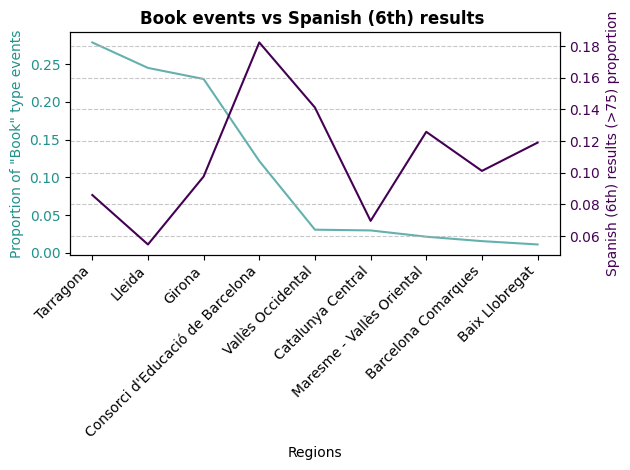

In [24]:
df_tot_comp_6e_1 = df_tot_comp_6e.copy()
df_tot_cultura_1 = df_tot_cultura.copy()


df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "llibres-i-lletres"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

df_tot_comp_6e_1["pcast_6e"] = pd.to_numeric(df_tot_comp_6e_1["pcast_6e"], errors="coerce")


# Obtaining the proportions by region of the marks >75 in Spanish 
df_castellano_75 = df_tot_comp_6e_1[df_tot_comp_6e_1["pcast_6e"] > 75]
proporcion_por_comarca = (
    df_castellano_75.groupby("area_territorial_6e")["pcast_6e"]
    .count()
    .reset_index(name="count")
)

proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

#Organizing and matching regions of the dataframe of cultural events and results of the Competències 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_6e",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Book" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Spanish (6th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Book events vs Spanish (6th) results ", fontweight="bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


C:\Users\judit\AppData\Local\Temp\ipykernel_10460\2525846950.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


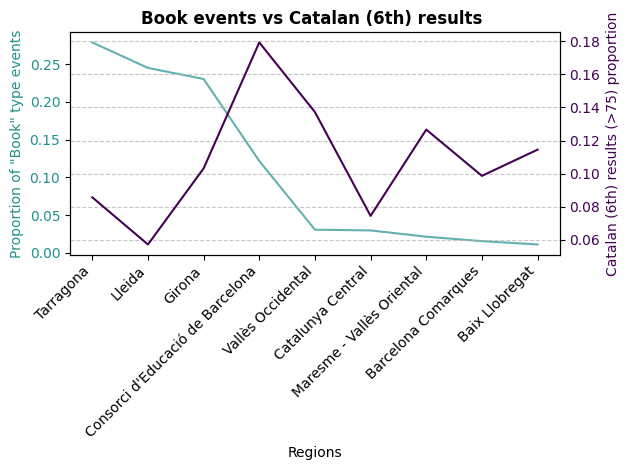

In [25]:
df_tot_comp_6e_1 = df_tot_comp_6e.copy()
df_tot_cultura_1 = df_tot_cultura.copy()


df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "llibres-i-lletres"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()


#Obtaining the proportions by region of the >75 results in Catalan 
df_tot_comp_6e_1["pcat_6e"] = pd.to_numeric(df_tot_comp_6e_1["pcat_6e"], errors="coerce")
df_cat_75 = df_tot_comp_6e_1[df_tot_comp_6e_1["pcat_6e"] > 75]
proporcion_por_comarca = (
    df_cat_75.groupby("area_territorial_6e")["pcast_6e"]
    .count()
    .reset_index(name="count")
)
proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organising and matching the regions in Agenda Cultural and results of Competències Bàsiques 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_6e",
    how="inner",
)


#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Book" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Catalan (6th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Book events vs Catalan (6th) results ", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Sciences - Popular science events

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\814764461.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


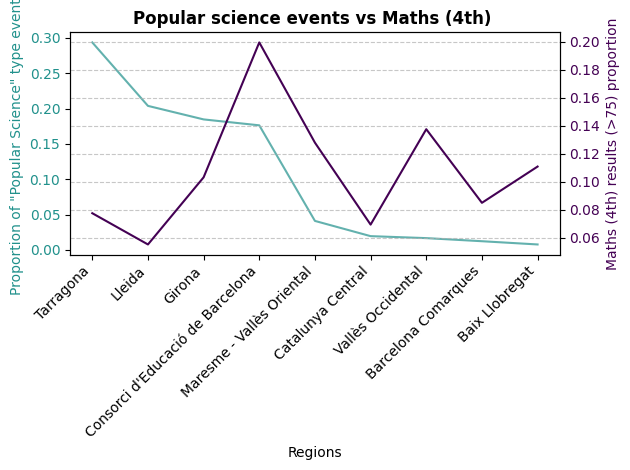

In [26]:
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_cultura_1 = df_tot_cultura.copy()

df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "divulgacio"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

df_tot_comp_4t_1["pmat_4t"] = pd.to_numeric(df_tot_comp_4t_1["pmat_4t"], errors="coerce")

#Obtaining the proportions by region of the >75 results in Maths 
df_mat_75 = df_tot_comp_4t_1[df_tot_comp_4t_1["pmat_4t"] > 75]

proporcion_por_comarca = (
    df_mat_75.groupby("area_territorial_4t")["pmat_4t"]
    .count()
    .reset_index(name="count")
)


proporcion_por_comarca["proportion"] = (proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum())

# Organising and matching the regions in Agenda Cultural and results of Competències Bàsiques
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_4t",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Popular Science" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Maths (4th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Popular science events vs Maths (4th) ", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



C:\Users\judit\AppData\Local\Temp\ipykernel_10460\2531967186.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


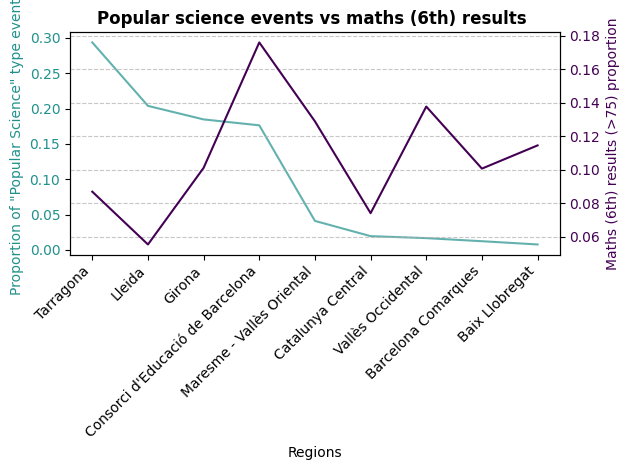

In [27]:
df_tot_comp_6e_1 = df_tot_comp_6e.copy()
df_tot_cultura_1 = df_tot_cultura.copy()

df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "divulgacio"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)



#Obtaining the proportions of >75 results in maths by region
df_tot_comp_6e_1["pmat_6e"] = pd.to_numeric(df_tot_comp_6e_1["pmat_6e"], errors="coerce")
df_mat_75 = df_tot_comp_6e_1[df_tot_comp_6e_1["pmat_6e"] > 75]
proporcion_por_comarca = (
    df_mat_75.groupby("area_territorial_6e")["pmat_6e"]
    .count()
    .reset_index(name="count")
)

proporcion_por_comarca["proportion"] = ( proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum())

# Organizing and mtching the cultural and results on Competències Bàsiques data
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_6e",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Popular Science" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Maths (6th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Popular science events vs maths (6th) results ", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


C:\Users\judit\AppData\Local\Temp\ipykernel_10460\2471143310.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


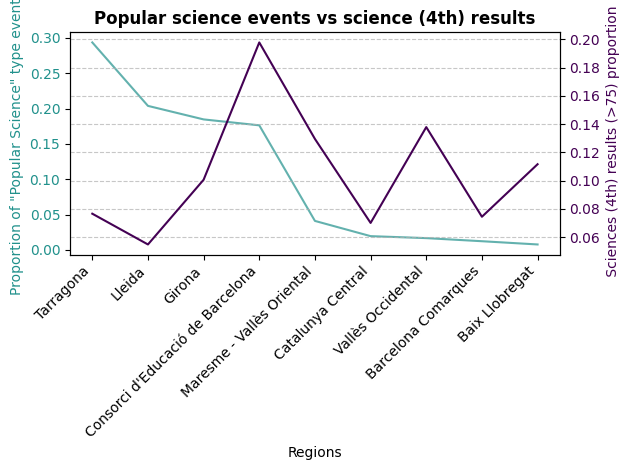

In [28]:
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_cultura_1 = df_tot_cultura.copy()

df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "divulgacio"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()


#Proportions of the >75 in sciences by region 
df_tot_comp_4t_1["pcien_4t"] = pd.to_numeric(df_tot_comp_4t_1["pcien_4t"], errors="coerce")
df_cien_75 = df_tot_comp_4t_1[df_tot_comp_4t_1["pcien_4t"] > 75]
proporcion_por_comarca = (
    df_cien_75.groupby("area_territorial_4t")["pcien_4t"]
    .count()
    .reset_index(name="count")
)
proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organising and matching regions in cultural events and results in Competències Bàsiques dataframes 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_4t",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Popular Science" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel(" Sciences (4th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Popular science events vs science (4th) results", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


C:\Users\judit\AppData\Local\Temp\ipykernel_10460\2329736273.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


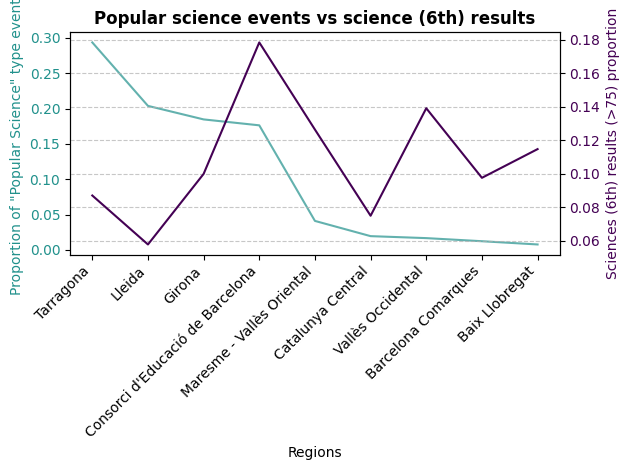

In [29]:
df_tot_comp_6e_1 = df_tot_comp_6e.copy()
df_tot_cultura_1 = df_tot_cultura.copy()

df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "divulgacio"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()

#Proportion of the sciences' marks >75 by regions 
df_tot_comp_6e_1["pcien_6e"] = pd.to_numeric(df_tot_comp_6e_1["pcien_6e"], errors="coerce")
df_cien_75 = df_tot_comp_6e_1[df_tot_comp_6e_1["pcien_6e"] > 75]
proporcion_por_comarca = (
    df_cien_75.groupby("area_territorial_6e")["pcien_6e"]
    .count()
    .reset_index(name="count")
)
proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organising and matching the regions in cultural events and Competències Bàsques dataframes 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_6e",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of "Popular Science" type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Sciences (6th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Popular science events vs science (6th) results", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Maths - Music events 

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\1043442235.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


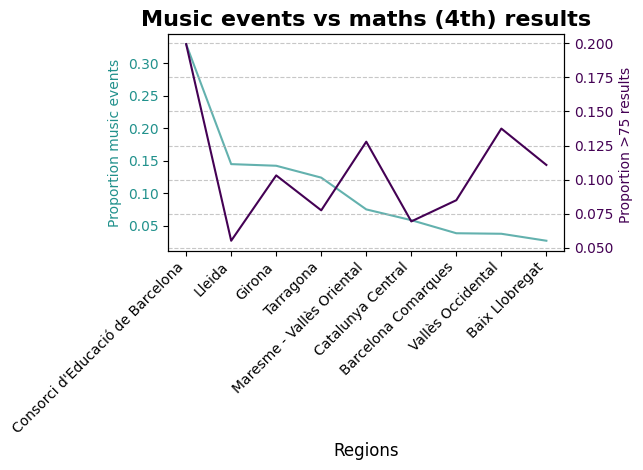

In [49]:
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_cultura_1 = df_tot_cultura.copy()

df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "musica"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()

#Proportion of the >75 marks in maths by region 
df_tot_comp_4t_1["pmat_4t"] = pd.to_numeric(df_tot_comp_4t_1["pmat_4t"], errors="coerce")
df_mat_75 = df_tot_comp_4t_1[df_tot_comp_4t_1["pmat_4t"] > 75]
proporcion_por_comarca = (
    df_mat_75.groupby("area_territorial_4t")["pmat_4t"]
    .count()
    .reset_index(name="count")
)

proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organising and matching the regions in Competències Bàsiques and Agenda Cultural dataframes
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_4t",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion music events', color="#21918C", fontsize = 10)
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions", fontsize = 12 )
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Proportion >75 results ", color="#440154", fontsize = 10 )
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Music events vs maths (4th) results", fontsize = 16, fontweight= "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("CDF- Musica-mates-4t.png", format="png", dpi=300)
plt.show()

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\2868255523.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


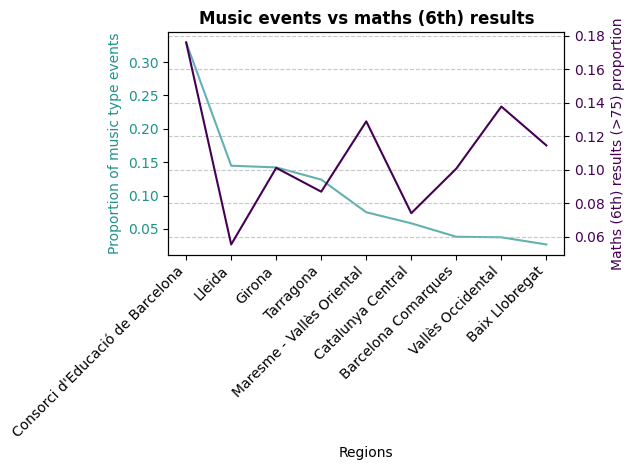

In [32]:
df_tot_comp_6e_1 = df_tot_comp_6e.copy()
df_tot_cultura_1 = df_tot_cultura.copy()

df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "musica"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()


#Proportion of the >75 marks in maths by region 
df_tot_comp_6e_1["pmat_6e"] = pd.to_numeric(df_tot_comp_6e_1["pmat_6e"], errors="coerce")
df_mat_75 = df_tot_comp_6e_1[df_tot_comp_6e_1["pmat_6e"] > 75]
proporcion_por_comarca = (
    df_mat_75.groupby("area_territorial_6e")["pmat_6e"]
    .count()
    .reset_index(name="count")
)
proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organizing and matching regions of the cultural events and the results in Competències Bàsiques 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_6e",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of music type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Maths (6th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Music events vs maths (6th) results", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Science - Music events

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\4291966931.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


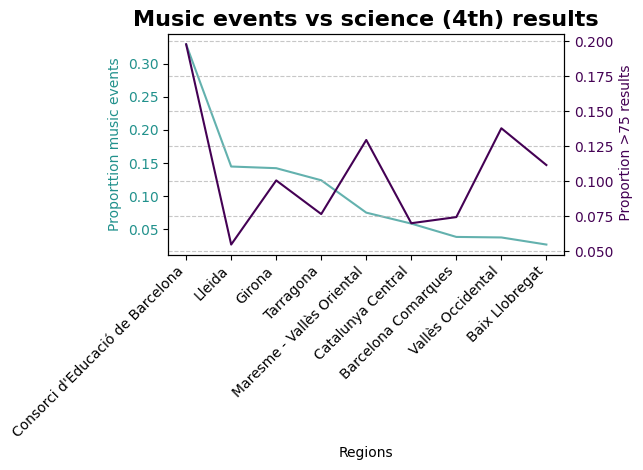

In [50]:
df_tot_comp_4t_1 = df_tot_comp_4t.copy()
df_tot_cultura_1 = df_tot_cultura.copy()


df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "musica"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

# Calcular la inversa de la CDF
eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()

#Proportion of the >75 results in sciences by region 
df_tot_comp_4t_1["pcien_4t"] = pd.to_numeric(df_tot_comp_4t_1["pcien_4t"], errors="coerce")
df_cien_75 = df_tot_comp_4t_1[df_tot_comp_4t_1["pcien_4t"] > 75]
proporcion_por_comarca = (
    df_cien_75.groupby("area_territorial_4t")["pcien_4t"]
    .count()
    .reset_index(name="count")
)
proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organising and matching regions in the Agenda Cultural and Competències Bàsiques dataframes 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_4t",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Book" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proporttion music events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel(" Proportion >75 results", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Music events vs science (4th) results", fontweight = "bold", fontsize = 16)
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("Musica-ciencia4tCDF.png", format="png", dpi=300)
plt.show()

C:\Users\judit\AppData\Local\Temp\ipykernel_10460\269947447.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right")


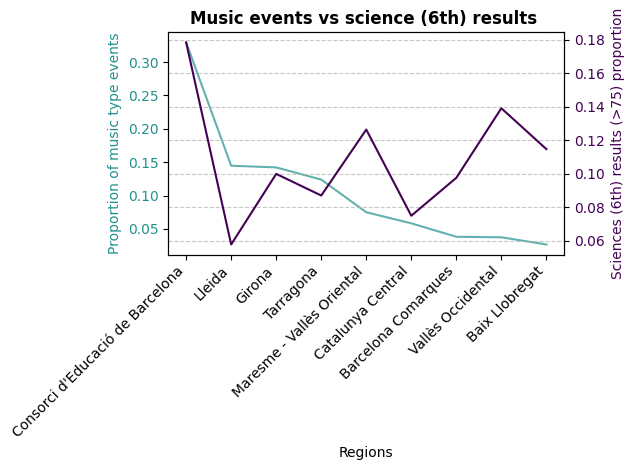

In [34]:
df_tot_comp_6e_1 = df_tot_comp_6e.copy()
df_tot_cultura_1 = df_tot_cultura.copy()


df_filtrado = df_tot_cultura[df_tot_cultura["tags_mbits"] == "musica"]


# Count events by region  
eventos_por_comarca = df_filtrado.groupby("area_territorial").size().reset_index(name="Eventos")
eventos_por_comarca["Proporción"] = eventos_por_comarca["Eventos"] / eventos_por_comarca["Eventos"].sum()
eventos_por_comarca = eventos_por_comarca.sort_values(by="Proporción", ascending=False)

eventos_por_comarca["Inverse_CDF"] = 1- eventos_por_comarca["Proporción"].cumsum()

#Proportion of marks >75 in sciences by region 
df_tot_comp_6e_1["pcien_6e"] = pd.to_numeric(df_tot_comp_6e_1["pcien_6e"], errors="coerce")
df_cien_75 = df_tot_comp_6e_1[df_tot_comp_6e_1["pcien_6e"] > 75]
proporcion_por_comarca = (
    df_cien_75.groupby("area_territorial_6e")["pcien_6e"]
    .count()
    .reset_index(name="count")
)
proporcion_por_comarca["proportion"] = (
    proporcion_por_comarca["count"] / proporcion_por_comarca["count"].sum()
)

# Organising and matching the regions in Agenda cultural and Competències Bàsiques dataframes 
proporcion_por_comarca = proporcion_por_comarca.sort_values(by="proportion", ascending=False)
merged_data = pd.merge(
    eventos_por_comarca,
    proporcion_por_comarca,
    left_on="area_territorial",
    right_on="area_territorial_6e",
    how="inner",
)

#Plot 
fig, ax1 = plt.subplots()

# In the y-axis (left) we'll put the cultural events 
ax1.plot(
    merged_data["area_territorial"],
    merged_data["Proporción"],
    alpha=0.7,
    label='"Music" type events proportion ',
    color="#21918C",
)
ax1.set_ylabel('Proportion of music type events', color="#21918C")
ax1.tick_params(axis="y", labelcolor="#21918C")
ax1.set_xlabel("Regions")
ax1.set_xticklabels(merged_data["area_territorial"], rotation=45, ha="right") 

# In the y-axis (right) we'll put the proportion of marks >75 by area 
ax2 = ax1.twinx()
ax2.plot(
    merged_data["area_territorial"],
    merged_data["proportion"],
    color="#440154",
#    marker="o",
#    label="Proporción de Notas (>75)",
)
ax2.set_ylabel("Sciences (6th) results (>75) proportion", color="#440154")
ax2.tick_params(axis="y", labelcolor="#440154")

# Plot settings 
plt.title("Music events vs science (6th) results ", fontweight = "bold")
fig.tight_layout()
#plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()